In [1]:
import numpy as np
import pandas as pd
import polars as po
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = True
import matplotlib.pyplot as plt
import os
import warnings
import itertools
import pickle

import fincoretails.lognormal as lognormal
import fincoretails.general_algpareto as powL
from fincoretails import loglikelihood_ratio

import polars as po

from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale

from scipy.special import erfinv


import torch
import torch.nn as nn
import torch.optim as optim

from lstm_network import LSTM_network
from captum.attr import IntegratedGradients


sns.set_theme(style='whitegrid', font='fira sans')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#%matplotlib widget

COLOURS = [
    '#00997D', # Paolo Veronese green
    '#a20252', # Jazzberry jam
    '#cc5803', # Tenne tawny
    '#81d473', # Mantis
    '#745296', # Royal purple
    '#555555', # Grey
    '#f5cc00', # Jonquil 
    '#679bf0', # Guilliman blue 
]



2025-01-17 17:25:17.941909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 17:25:17.971857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 17:25:17.981265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 17:25:17.984668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 17:25:18.019378: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
from matplotlib import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=COLOURS)

In [3]:
DATA_PARQUET_PATH = 'hope_data/EWS_0326_klar.parquet'
df = pd.read_parquet(DATA_PARQUET_PATH)

# Time series data

df['Day'] = df['Timings_dateFinish'] # We use the date when the survey is submitted as a basis
df['Week'] = df['Day'].dt.to_period('W').dt.start_time
df['Month'] = df['Day'].dt.to_period('M').dt.start_time
df['Year'] = df['Day'].dt.to_period('Y').dt.start_time

print(f"Survey data from {df['Day'].min()} to {df['Day'].max()}")

df = df[(df['Day'] >= '2020-07-01') & (df['Day'] < '2022-01-01')]

AGE_ORDER = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']

Survey data from 2020-05-16 00:00:00 to 2022-03-26 00:00:00


In [4]:
df['# contacts'] = df['Q4a_1'] + df['Q4a_2'] + df['Q4a_3'] + df['Q4a_4']
df['Age group'] = df['aldercat'].map({
    '18-29 år': '18-29', 
    '30-39 år': '30-39', 
    '40-49 år': '40-49', 
    '50-59 år': '50-59', 
    '60-69 år': '60-69', 
    '70 år +': '70+'
})
df_raw = df

## Robust estimator for the median of the number of contacts distribution

In [5]:
res = dict()

pd_df = df_raw

df = po.DataFrame(df_raw)

for aldercat in AGE_ORDER + ['18+']:
    if aldercat != '18+':
        this_df = df.filter(po.col('Age group') == aldercat)
    else:
        print("using whole data set")
        this_df = df

    days = this_df['Day'].cast(po.Date).to_numpy()
    contacts = this_df['# contacts'].to_numpy()
    intdays = (days-days[0])
    intdays = intdays.astype(int)
    unique_int_days = np.sort(np.unique(intdays))
    unique_days = days[0] + unique_int_days.astype(np.timedelta64(1,'D'))
    
    unique_weeks = this_df['Week'].unique().sort()
    
    be = np.logspace(1,5,101)
    be = np.concatenate([np.arange(1,10), be])

    mus, sigmas = [], []
    means = []
    medians = []
    contact_numbers = []
    
    for j in tqdm(range(3,len(unique_int_days)-3)):
        ndx = np.where(np.logical_and(intdays>=j-3,intdays<=j+3))[0]
        Ncont = contacts[ndx]
        N0 = np.count_nonzero(Ncont == 0.0)
        Ncont = Ncont[np.logical_and(Ncont>0,Ncont<1e6)]
        p0 = N0 / (N0 + len(Ncont))

        data = Ncont

        mu, sigma = lognormal.mu_and_sigma(data)

        mean = (1-p0) * np.exp(mu + sigma**2/2)
        variance = (1-p0) * (np.exp(sigma**2)-1) * np.exp(2*mu+sigma**2)
        k2 = variance + mean**2
        contact_number = k2/mean
        
        #print(p0)
        
        if p0 > 0.5:
            median = 0
        else:
            q = (0.5-p0)/(1-p0)
            median = np.exp(mu + sigma*np.sqrt(2)*erfinv(2*q-1))
            
        means.append(mean)
        contact_numbers.append(contact_number)
        medians.append(median)
        
    #mus = np.array(mus)
    #sigmas = np.array(sigmas)
    plotdays = unique_days[3:-3]
    
    
    res[aldercat] = (means, medians, contact_numbers)
    
df = pd_df

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

using whole data set


  0%|          | 0/543 [00:00<?, ?it/s]

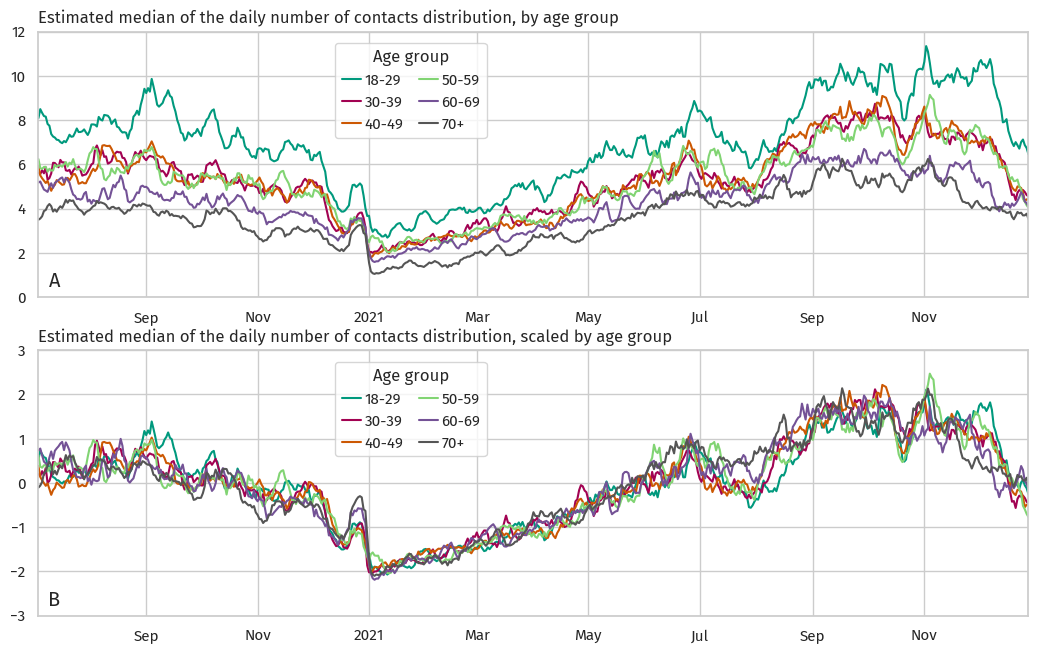

In [6]:
DAYS = unique_days[3:-3]

contact_data = {'days':DAYS,'raw':{}, 'scaled':{}}

_, axs = plt.subplots(2, 1, figsize=(12, 8))
for a, aldercat in enumerate(AGE_ORDER):
    contact_data['raw'][aldercat] = res[aldercat][1]
    sns.lineplot(
        x=DAYS, y=res[aldercat][1], color=COLOURS[a], label=aldercat, ax=axs[0]
    ).set(title='Estimated median of the daily number of contacts distribution, by age group', xlim=(min(DAYS), max(DAYS)))
    sns.move_legend(axs[0], loc=(0.3,0.6), title='Age group', ncols=2)
    
    contact_data['scaled'][aldercat] = scale(res[aldercat][1])
    sns.lineplot(
        x=DAYS, y=scale(res[aldercat][1]), color=COLOURS[a], label=aldercat, ax=axs[1]
    ).set(title='Estimated median of the daily number of contacts distribution, scaled by age group', xlim=(min(DAYS), max(DAYS)))
    sns.move_legend(axs[1], loc=(0.3,0.6), title='Age group', ncols=2)
    
contact_data['scaled']['18+'] = scale(res['18+'][1])
    
with open('result_data/contact_data_daily.pickle','wb') as f:
    pickle.dump(contact_data, f)
    
axs[0].annotate("A", xy=(10, 10), xycoords="axes pixels", fontweight='semibold', fontsize='large')
axs[1].annotate("B", xy=(10, 10), xycoords="axes pixels", fontweight='semibold', fontsize='large')
    
plt.savefig('figures/paper/n_contacts.png', bbox_inches='tight', pad_inches=0., dpi=500)



In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Root mean squared error
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

# Mean absolute percentage error
mape = lambda y_true, y_pred: 100 * np.mean(np.absolute((y_true - y_pred) / y_true))

rmsre = lambda y_true, y_pred: 100 * np.sqrt(np.mean(np.absolute((y_true - y_pred) / y_true)**2))

y_t = scale(res['18+'][1])

M = {aldercat: np.mean(med) for aldercat, (_, med, _) in res.items()}
S = {aldercat: np.std(med) for aldercat, (_, med, _) in res.items()}
RMSE = {aldercat: rmse(med, y_t * S[aldercat] + M[aldercat]) for aldercat, (_, med, _) in res.items()}
MAPE = {aldercat: mape(med, y_t * S[aldercat] + M[aldercat]) for aldercat, (_, med, _) in res.items()}
RMSRE = {aldercat: rmsre(med, y_t * S[aldercat] + M[aldercat]) for aldercat, (_, med, _) in res.items()}

reconstruction = pd.DataFrame.from_dict({aldercat: (M[aldercat], S[aldercat], RMSE[aldercat], MAPE[aldercat], RMSRE[aldercat]) for aldercat in AGE_ORDER}, orient='index', columns=['Mean', 'Standard deviation', 'Reconstruction RMSE', 'Reconstruction MAPE', 'Reconstruction RMSRE'])
reconstruction = reconstruction.style.format({'Reconstruction MAPE': '{:.2f}\%'.format,
                                              'Reconstruction RMSRE': '{:.2f}\%'.format}, precision=2)
reconstruction

In [8]:
def to_latex(df,short={'Mean':'Mean', 'Standard deviation':'Std. Dev.', 'Reconstruction RMSE': 'RMSE', 'Reconstruction MAPE':'MAPE','Reconstruction RMSRE': 'RMSRE'}):
    s = df.to_latex()
    lines = s.split('\n')
    header = lines[1][:-3].split(' & ')
    header = ' & '.join([fr'\textbf{{{short[title]}}}' if title != '' else '' for title in header])
    header += r'\\'
    header = '    '  + header
    lines = [
        lines[0],
        r'    \toprule',
        header,
        r'    \midrule'        
    ] + [ '    ' + l for l in lines[2:-2] ] + [
        r'    \bottomrule',
        r'\end{tabular}',
        ''
    ]
    return '    ' + '\n    '.join(lines)

print(to_latex(reconstruction))

    \begin{tabular}{lrrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE} & \textbf{RMSRE}\\
        \midrule
        18-29 & 6.98 & 2.07 & 0.49 & 5.27\% & 6.68\% \\
        30-39 & 5.30 & 1.62 & 0.29 & 4.56\% & 5.81\% \\
        40-49 & 5.27 & 1.73 & 0.33 & 5.40\% & 6.66\% \\
        50-59 & 5.25 & 1.57 & 0.35 & 5.15\% & 6.61\% \\
        60-69 & 4.27 & 1.23 & 0.32 & 5.69\% & 7.24\% \\
        70+ & 3.62 & 1.23 & 0.36 & 7.63\% & 9.52\% \\
        \bottomrule
    \end{tabular}
    


### Extending this study to other variables

#### Sex

In [10]:
df['Sex'] = df['koen'].map({
    'Mand': 'Male',
    'Kvinde': 'Female'
})

SEX_ORDER = ['Female', 'Male']

In [11]:
def study_demographic(pd_df, column_label, column_order):
    # Compute
    res = dict()  
    df = po.DataFrame(pd_df)
    
    for aldercat in column_order + ['Together']:
        if aldercat != 'Together':
            this_df = df.filter(po.col(column_label) == aldercat)
        else:
            print("using whole data set")
            this_df = df
    
        days = this_df['Day'].cast(po.Date).to_numpy()
        contacts = this_df['# contacts'].to_numpy()
        intdays = (days-days[0]).astype(int)

        days_all = df['Day'].cast(po.Date).to_numpy()
        intdays_all = (days_all-days_all[0]).astype(int)
        unique_int_days = np.sort(np.unique(intdays_all))
        unique_days = days[0] + unique_int_days.astype(np.timedelta64(1,'D'))
        
        unique_weeks = this_df['Week'].unique().sort()
        
        be = np.logspace(1,5,101)
        be = np.concatenate([np.arange(1,10), be])
    
        mus, sigmas = [], []
        means = []
        medians = []
        contact_numbers = []

        for j in tqdm(range(3,len(unique_int_days)-3)):
            ndx = np.where(np.logical_and(intdays>=j-3,intdays<=j+3))[0]
            Ncont = contacts[ndx]
            N0 = np.count_nonzero(Ncont == 0.0)
            Ncont = Ncont[np.logical_and(Ncont>0,Ncont<1e6)]
            p0 = N0 / (N0 + len(Ncont))

            data = Ncont

            mu, sigma = lognormal.mu_and_sigma(data)

            mean = (1-p0) * np.exp(mu + sigma**2/2)
            variance = (1-p0) * (np.exp(sigma**2)-1) * np.exp(2*mu+sigma**2)
            k2 = variance + mean**2
            contact_number = k2/mean

            #print(p0)

            if p0 > 0.5:
                median = 0
            else:
                q = (0.5-p0)/(1-p0)
                median = np.exp(mu + sigma*np.sqrt(2)*erfinv(2*q-1))

            means.append(mean)
            contact_numbers.append(contact_number)
            medians.append(median)
        
        res[aldercat] = (means, medians, contact_numbers)

    df = pd_df
    # Plot
    DAYS = unique_days[3:-3]

    _, axs = plt.subplots(2, 1, figsize=(12, 8))
    for a, aldercat in enumerate(column_order):
        sns.lineplot(
            x=DAYS, y=res[aldercat][1], color=COLOURS[a], label=aldercat, ax=axs[0]
        ).set(title=f'Estimated median of the daily number of contacts distribution, by {column_label.lower()}', xlim=(min(DAYS), max(DAYS)))
        sns.move_legend(axs[0], loc=(0.25,0.55), title=column_label, ncols=2)
        
        sns.lineplot(
            x=DAYS, y=scale(res[aldercat][1]), color=COLOURS[a], label=aldercat, ax=axs[1]
        ).set(title=f'Estimated median of the daily number of contacts distribution, scaled by {column_label.lower()}', xlim=(min(DAYS), max(DAYS)))
        sns.move_legend(axs[1], loc=(0.25,0.55), title=column_label, ncols=2)
        
    axs[0].annotate("A", xy=(10, 10), xycoords="axes pixels", fontweight='semibold', fontsize='large')
    axs[1].annotate("B", xy=(10, 10), xycoords="axes pixels", fontweight='semibold', fontsize='large')
        
    plt.savefig(f'figures/paper/n_contacts_{column_label.lower()}.png', bbox_inches='tight', pad_inches=0., dpi=500)

    # Compute metrics
    y_t = scale(res['Together'][1])

    M = {aldercat: np.mean(med) for aldercat, (_, med, _) in res.items()}
    S = {aldercat: np.std(med) for aldercat, (_, med, _) in res.items()}
    RMSE = {aldercat: rmse(med, y_t * S[aldercat] + M[aldercat]) for aldercat, (_, med, _) in res.items()}
    MAPE = {aldercat: mape(med, y_t * S[aldercat] + M[aldercat]) for aldercat, (_, med, _) in res.items()}
    
    reconstruction = pd.DataFrame.from_dict({aldercat: (M[aldercat], S[aldercat], RMSE[aldercat], MAPE[aldercat])for aldercat in column_order}, orient='index', columns=['Mean', 'Standard deviation', 'Reconstruction RMSE', 'Reconstruction MAPE'])
    reconstruction = reconstruction.style.format({'Reconstruction MAPE': '{:.2f}\%'.format}, precision=2)
    return reconstruction

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

using whole data set


  0%|          | 0/543 [00:00<?, ?it/s]

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        Female & 4.70 & 1.47 & 0.11 & 1.89\% \\
        Male & 5.49 & 1.66 & 0.14 & 1.97\% \\
        \bottomrule
    \end{tabular}
    


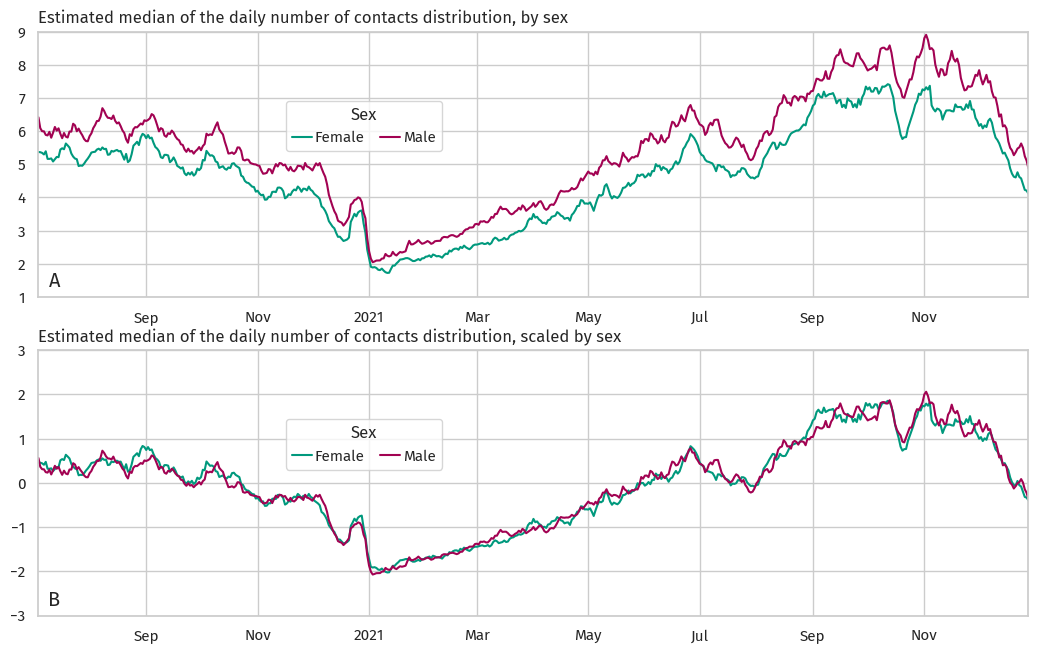

In [12]:
study_sex = study_demographic(df, 'Sex', SEX_ORDER)
print(to_latex(study_sex))
study_sex

#### Occupation

In [13]:
for x in df['Q14'].unique():
    print(x)

Under uddannelse
Lønmodtager i en privat virksomhed
Lønmodtager i det offentlige (stat, kommune eller region)
Pensionist eller efterlønsmodtager
Arbejdsløs
Andet
Selvstændig


In [14]:
df['Occupation'] = df['Q14'].map({
    'Under uddannelse': 'Student',
    'Lønmodtager i en privat virksomhed': 'Employed (private)',
    'Lønmodtager i det offentlige (stat, kommune eller region)': 'Employed (public)',
    'Pensionist eller efterlønsmodtager': 'Pensioner',
    'Arbejdsløs': 'Unemployed',
    'Andet': 'Other',
    'Selvstændig': 'Independent',
})

OCCUPATION_ORDER = ['Student', 'Employed (private)', 'Employed (public)', 'Independent', 'Unemployed', 'Pensioner', 'Other']

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

using whole data set


  0%|          | 0/543 [00:00<?, ?it/s]

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        Student & 6.95 & 2.69 & 0.96 & 11.67\% \\
        Employed (private) & 5.95 & 1.71 & 0.23 & 3.23\% \\
        Employed (public) & 5.97 & 1.91 & 0.39 & 5.62\% \\
        Independent & 5.28 & 1.61 & 0.65 & 8.80\% \\
        Unemployed & 3.65 & 1.06 & 0.65 & 13.87\% \\
        Pensioner & 3.48 & 1.11 & 0.30 & 6.70\% \\
        Other & 3.80 & 1.09 & 0.61 & 12.43\% \\
        \bottomrule
    \end{tabular}
    


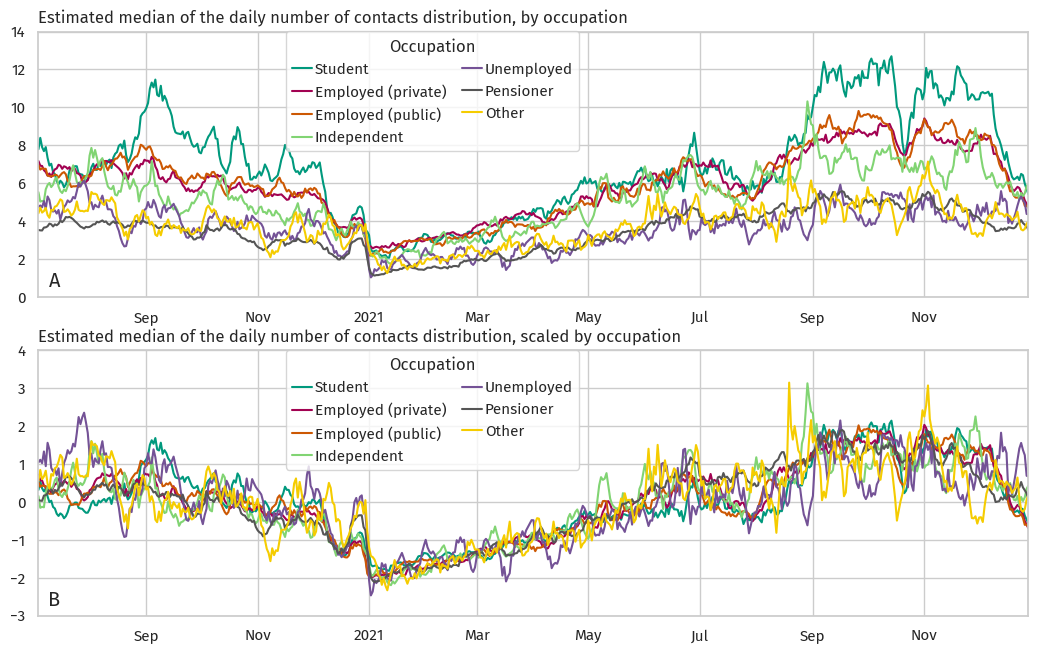

In [15]:
study_occupation = study_demographic(df, 'Occupation', OCCUPATION_ORDER)
print(to_latex(study_occupation))
study_occupation

#### Education

In [16]:
for x in df['Q10'].unique():
    print(x)

Bachelor (fx 1. del af en lang videregående uddannelse)
Erhvervsfaglig uddannelse (fx tømrer, frisør eller kontorassistent)
Korte videregående (fx laborant eller datamatiker)
Mellemlang videregående (fx teknikum ingeniør eller lærer)
Gymnasie (STX, HF, HHX , HTX og lign.)
Lang videregående (fx gymnasielærer, økonom eller jurist)
Grundskole (folkeskole, privatskole, efterskole)
Ph.D og forskeruddanelser


In [17]:
df['Education'] = df['Q10'].map({
    'Bachelor (fx 1. del af en lang videregående uddannelse)': 'Bachelor',
    'Erhvervsfaglig uddannelse (fx tømrer, frisør eller kontorassistent)': 'Vocational training',
    'Korte videregående (fx laborant eller datamatiker)': 'Short higher education',
    'Mellemlang videregående (fx teknikum ingeniør eller lærer)': 'Intermediate higher education',
    'Lang videregående (fx gymnasielærer, økonom eller jurist)': 'Advanced higher education',
    'Gymnasie (STX, HF, HHX , HTX og lign.)': 'High school',
    'Grundskole (folkeskole, privatskole, efterskole)': 'Primary school',
    'Ph.D og forskeruddanelser': 'Doctorate',
})

EDUCATION_ORDER = ['Primary school', 'High school', 'Vocational training', 'Bachelor', 'Short higher education', 'Intermediate higher education', 'Advanced higher education', 'Doctorate']

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

using whole data set


  0%|          | 0/543 [00:00<?, ?it/s]

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        Primary school & 4.92 & 1.33 & 0.39 & 6.20\% \\
        High school & 6.47 & 2.04 & 0.57 & 6.38\% \\
        Vocational training & 5.13 & 1.31 & 0.30 & 4.73\% \\
        Bachelor & 5.55 & 1.83 & 0.41 & 6.07\% \\
        Short higher education & 4.71 & 1.54 & 0.39 & 6.09\% \\
        Intermediate higher education & 4.94 & 1.61 & 0.28 & 4.19\% \\
        Advanced higher education & 4.50 & 1.79 & 0.32 & 6.98\% \\
        Doctorate & 4.16 & 2.17 & 0.97 & inf\% \\
        \bottomrule
    \end{tabular}
    


/tmp/ipykernel_19513/171900354.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = lambda y_true, y_pred: 100 * np.mean(np.absolute((y_true - y_pred) / y_true))


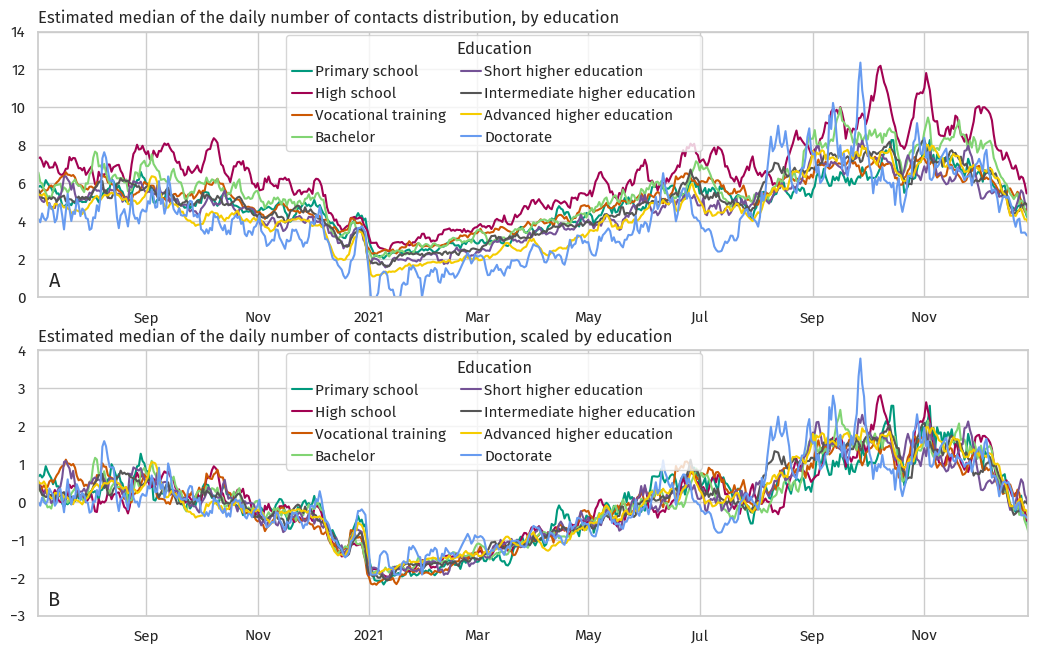

In [18]:
study_education = study_demographic(df, 'Education', EDUCATION_ORDER)
print(to_latex(study_education))
study_education

## Extracting behavioural features from the data

In [22]:
from sklearn.decomposition import NMF

QUESTIONS = ['Q1_1', 'Q1_2'] + \
            [f'Q2_{i}' for i in range(1, 7)] + \
            [f'Q3_{i}' for i in range(1, 8)] + \
            [f'Q5_{i}' for i in range(1, 6)] + \
            [f'Q6_{i}' for i in range(1, 10)] + \
            [f'Q7_{i}' for i in range(1, 6)]

QUESTIONS_LABELS = {
    'Q1_1': 'You are exposed regarding the Corona virus',
    'Q1_2': 'The Corona virus is a threat to Danish society',
    'Q2_1': 'It is easy for me to follow the advice of the health authorities',
    'Q2_2': 'I feel confident that I can follow the advice of the health authorities if I want to',
    'Q2_3': 'If I follow the advice of the health authorities, I will be as safe as possible during the corona epidemic',
    'Q2_4': 'If I follow the advice of the health authorities, I will help protect others from the corona virus',
    'Q2_5': 'If I follow the advice of the health authorities, my relationship with people outside the family will be impaired.',
    'Q2_6': 'If I follow the advice of the health authorities, my life will be degraded',
    'Q3_1': 'Ensure good hand hygiene by washing your hands frequently or using hand sprays',
    'Q3_2': 'Avoid physical contact',
    'Q3_3': 'Ensure frequent and thorough cleaning',
    'Q3_4': 'Keep away from elderly and chronically ill people',
    'Q3_5': 'Keep 1-2 meters distance to other people',
    'Q3_6': 'Minimize your going to places, where many people typically are going',
    'Q3_7': 'Minimize activities where you have contact to other people',
    'Q5_1': 'Others took you into account in relation to keeping distance',
    'Q5_2': 'Others supported the advice of the authorities to avoid spreading infection',
    'Q5_3': 'People did not care for each other in terms of spreading infection',
    'Q5_4': 'You yourself took others into account in terms of keeping distance',
    'Q5_5': 'You felt the urge to make a statement to others that they did not keep a enough distance',
    'Q6_1': 'The sanctions for not complying with the advice of the health authorities are harsh',
    'Q6_2': 'The health authorities advice are important in order to achieve a safe society',
    'Q6_3': 'I trust that the others I meet can avoid spreading infection',
    'Q6_4': 'The health authorities advice create a fair distribution of burdens',
    'Q6_5': 'I feel ownership of the health authorities advice',
    'Q6_6': 'I have been given clear information on the reasons for the health authorities advice',
    'Q6_7': 'The health authorities advice limits my daily activities to a high degree',
    'Q6_8': 'The advice of the health authorities are sufficient to prevent the spread of infection',
    'Q6_9': 'I trust the political strategy behind the health authorities advice',
    'Q7_1': 'Fever',
    'Q7_2': 'Cough',
    'Q7_3': 'Sore throat',
    'Q7_4': 'Disturbances in the smell and taste sense',
    'Q7_5': 'Shortness of breath',
}
    
df_red = df[QUESTIONS + ['Week', 'Day']].dropna(axis=0).copy()
for f in QUESTIONS:
    df_red[f] = df_red[f].rank(pct=True)
    
print(f'Working with {len(QUESTIONS)} questions')

Working with 34 questions


In [23]:
# Selecting the number of dimensions
from numpy.linalg import norm

res = pd.DataFrame(columns=['Dimensions', '||X - WxH||'])
X = df_red.drop(['Week', 'Day'], axis=1).values
meanX = X.ravel().mean()

for i in range(2, 11):
    nmf = NMF(i, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1, random_state=2020)
    W = nmf.fit_transform(X)
    H = nmf.components_

    res.loc[len(res)] = (i, norm((X - W@H)))
   


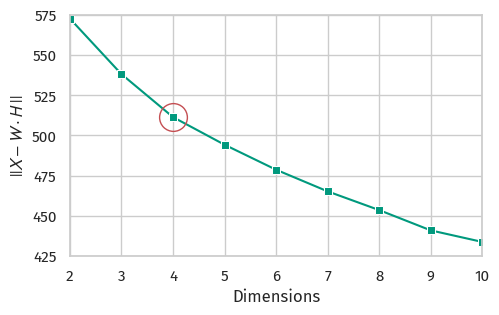

In [24]:
sns.lineplot(res, x='Dimensions', y='||X - WxH||',marker='s')
plt.ylabel('$||X - W \cdot H\ ||$')
plt.plot([4,],[511.8],'o',mfc='None',mec='r',ms=20)
plt.gcf().savefig('figures/paper/selecting_number_of_dimensions_nmf.pdf')


Shape of X: (200027, 34)
Shape of W: (200027, 4)
Shape of H: (4, 34)
Sample weights example:


array([[1.5344713 , 1.7091818 , 0.        , 0.0219745 ],
       [1.9890496 , 0.82258686, 1.56354194, 0.15352988],
       [1.90184173, 0.84905368, 1.32515805, 0.68057701],
       [0.66788315, 0.7980418 , 0.68311754, 1.79113407],
       [1.17855784, 1.74463353, 1.58268771, 0.        ],
       [2.27112213, 0.83398555, 0.89338687, 0.60920368],
       [1.46032089, 0.88862518, 1.41527353, 0.53268417],
       [0.75983971, 1.0898951 , 0.44417019, 1.49042699],
       [1.40805375, 1.15315207, 1.03461736, 0.16294211],
       [1.82371739, 0.82028788, 0.65304567, 0.61136362],
       [0.75443778, 1.87634739, 0.65534303, 0.88869144],
       [0.        , 0.78019479, 1.68949951, 1.39114521],
       [0.98484186, 0.35919944, 0.91185011, 1.81429562],
       [0.        , 1.11053356, 0.74880328, 1.29591965],
       [0.57345493, 1.3814853 , 0.37449318, 1.08751518],
       [2.01379946, 0.76584942, 1.20624358, 1.16755456],
       [0.67564861, 0.32347979, 0.63512302, 1.47219875],
       [0.36800842, 0.        ,

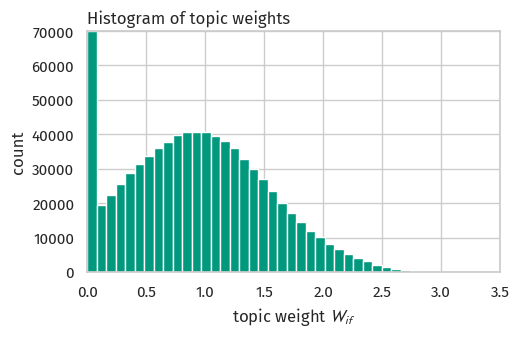

In [25]:
nmf = NMF(4, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1, random_state=2020)
W = nmf.fit_transform(X)
H = nmf.components_

print(f'Shape of X: {X.shape}')
print(f'Shape of W: {W.shape}')
print(f'Shape of H: {H.shape}')

print('Sample weights example:')
display(W[:20, :])

#sns.kdeplot(W.flatten()).set(title='Distribution of topic weights')
plt.figure()
plt.title('Histogram of topic weights')
plt.hist(W.flatten(),bins=40)
plt.ylabel('count')
plt.xlabel('topic weight $W_{if}$')
plt.gcf().savefig('figures/paper/topic_weight_distribution.pdf')


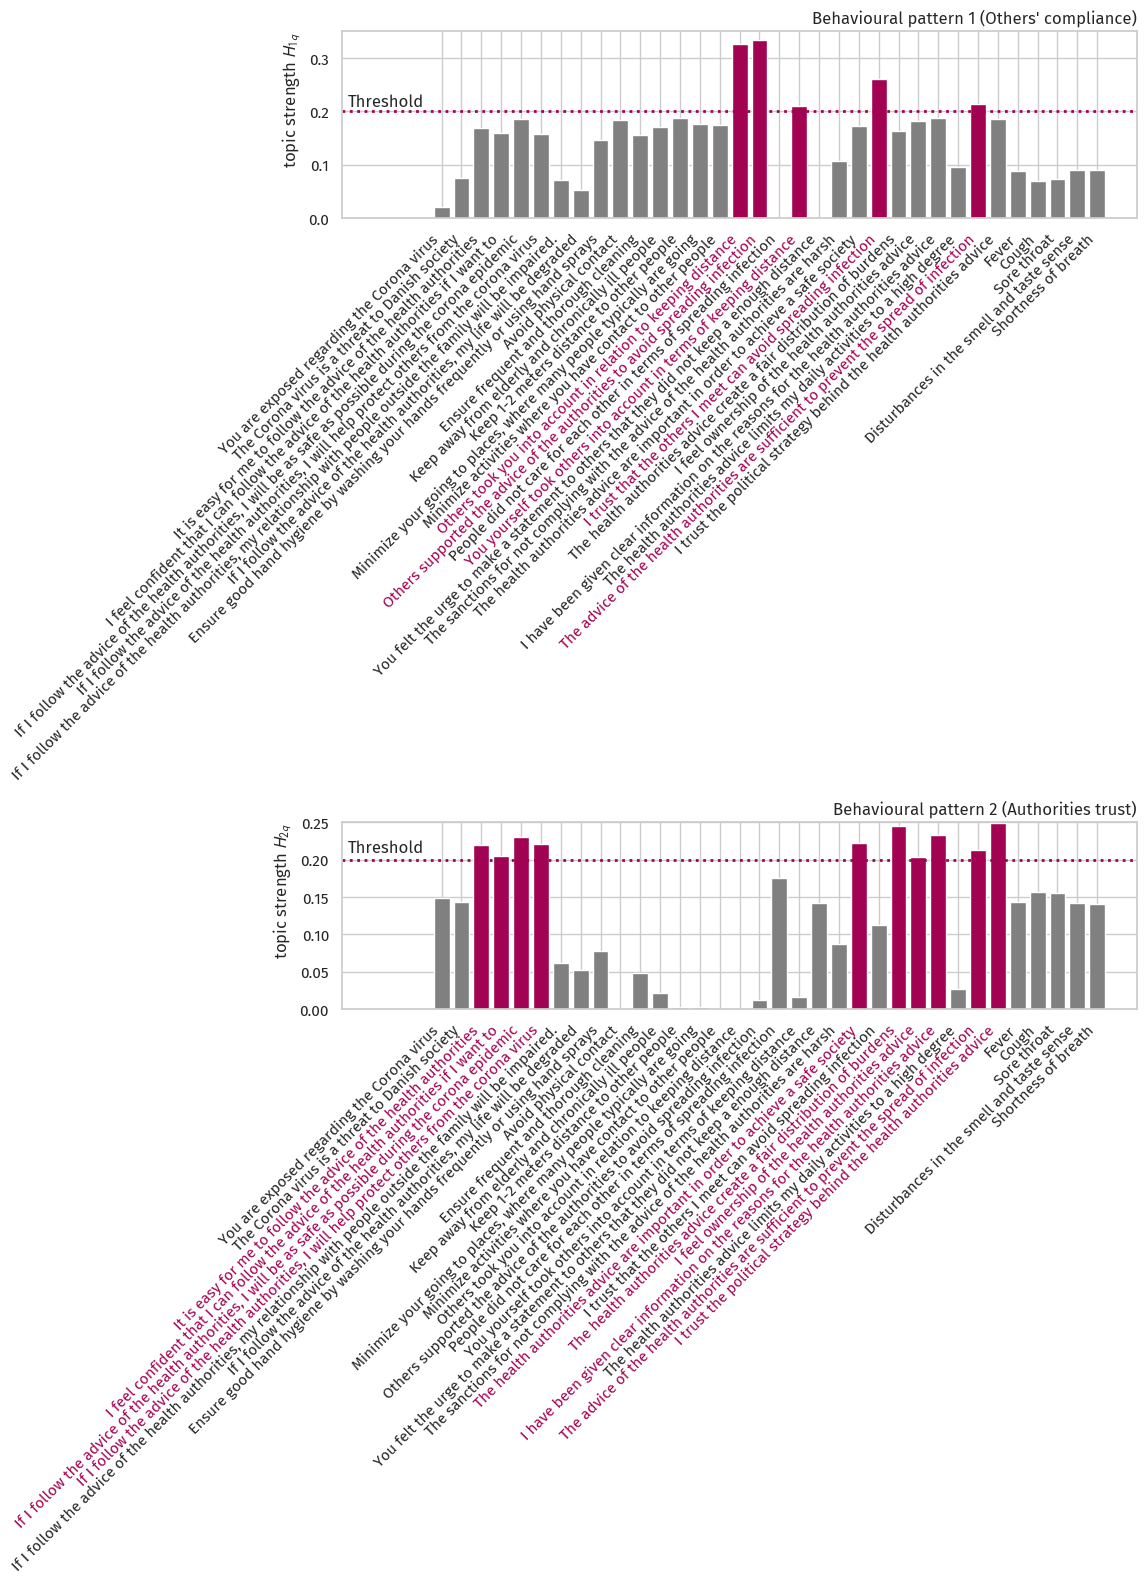

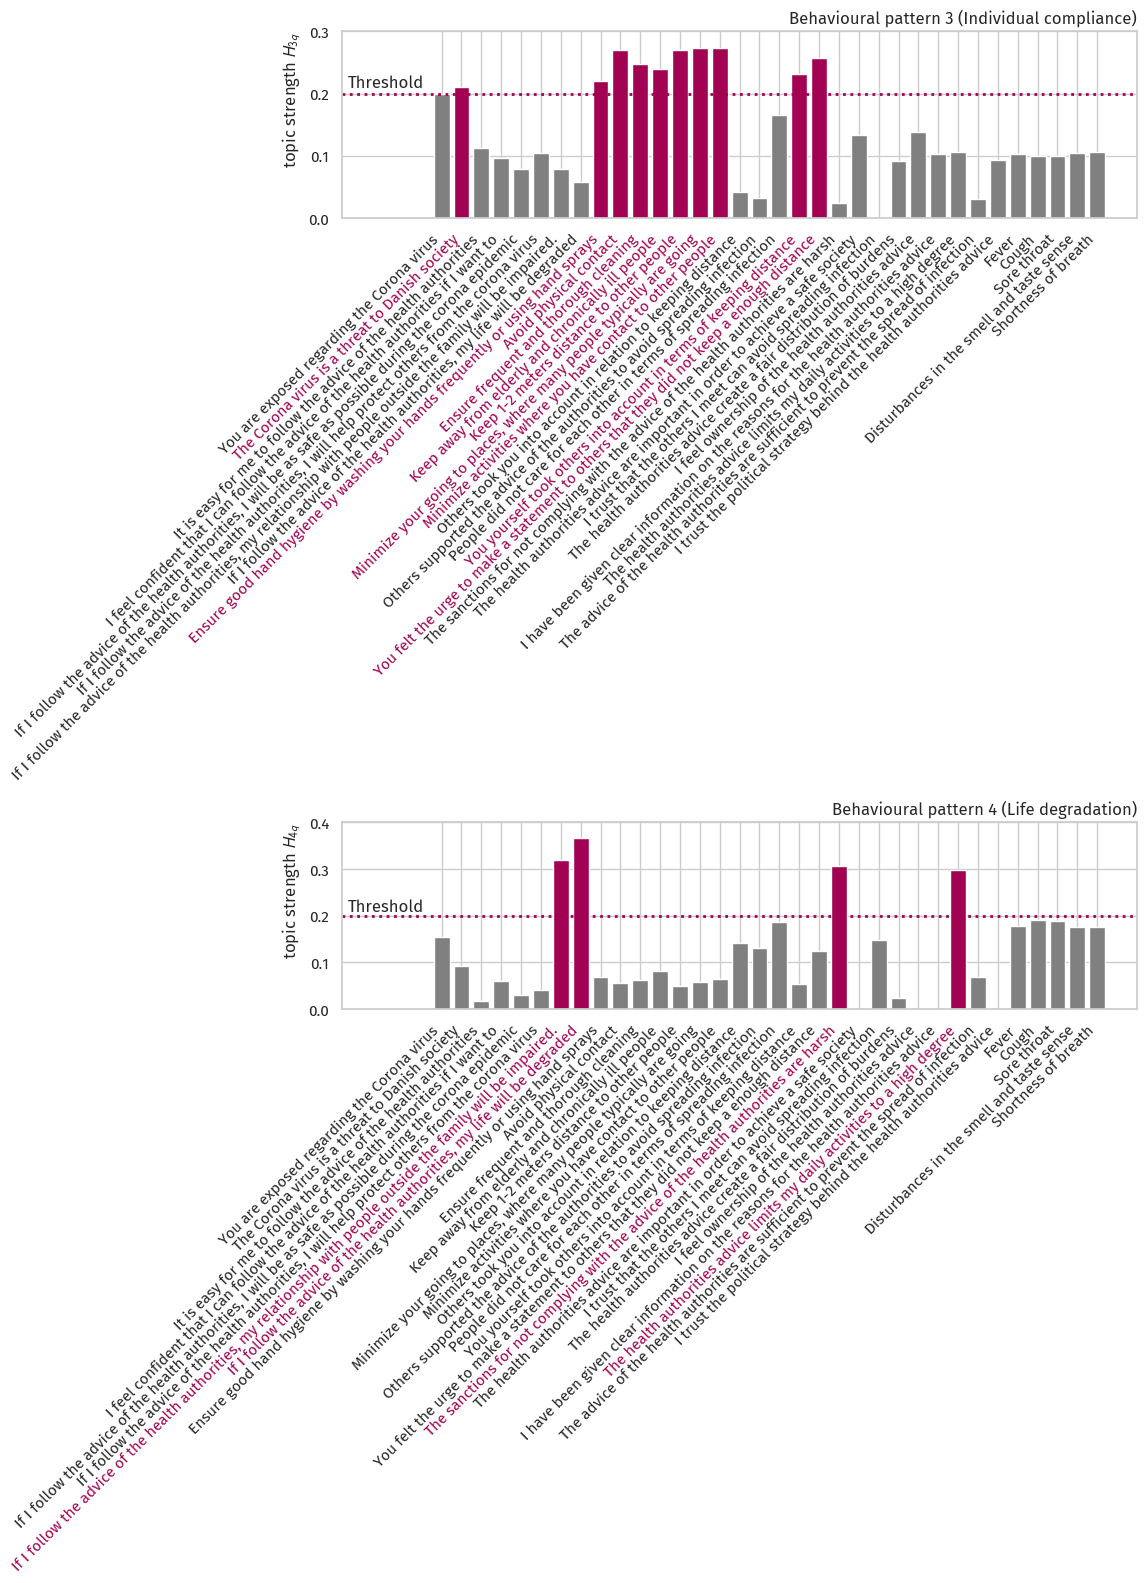

In [26]:
fig1, axs1 = plt.subplots(2, 1, figsize=(12, 8*2))
fig2, axs2 = plt.subplots(2, 1, figsize=(12, 8*2))

axs = axs1.tolist()+ axs2.tolist()
figs = [fig1, fig2]

FEATURES = ["Others' compliance",'Authorities trust','Individual compliance','Life degradation']

for i in range(H.shape[0]):
    x = np.arange(H.shape[1])
    y = H[i,:]
    ndx = np.where(y>0.2)[0]
    ndx2 = np.where(y<=0.2)[0]
    axs[i].bar(x[ndx], height=y[ndx], color=COLOURS[1])
    axs[i].bar(x[ndx2], height=y[ndx2], color='grey')
    axs[i].set_xticks(range(H.shape[1]), [QUESTIONS_LABELS[q] for q in QUESTIONS], rotation=45, ha='right')
    xticklabels = axs[i].get_xticklabels()
    for i in ndx:
        xticklabels[i].set_color(COLOURS[1]) 
    
for fig in figs:
    fig.subplots_adjust(hspace=2.0,left=0.4)

for i in range(H.shape[0]):
    axs[i].set_title(f'Behavioural pattern {i+1} ({FEATURES[i]})',loc='right')
    xlim = axs[i].get_xlim()
    axs[i].plot(xlim,[0.2,0.2],':',c= COLOURS[1],lw=2)
    axs[i].text(xlim[0]+0.3,0.21,'Threshold')
    axs[i].set_ylabel(f'topic strength $H_{{{i+1}q}}$',loc='top')

for fig in figs:
    fig.tight_layout()

for i, fig in enumerate(figs):
    fig.savefig(f'figures/paper/questions_clusters_strength_nmf_{i}.pdf')
#plt.show()

In [27]:
patterns = [np.array(QUESTIONS)[(H[i] > 0.2)] for i in range(H.shape[0])]
q_all = list()


for p, pattern in enumerate(patterns):
    print(fr'\subparagraph{{Pattern {p+1} ({FEATURES[p]})}}')
    print(r'\begin{itemize}')
    for q in pattern:
        q_all.append(q)
        print(fr'\item {QUESTIONS_LABELS[q]}')
    print(r'\end{itemize}')
    print()
    
print(f'Working with a total of {len(set(q_all))} questions')

\subparagraph{Pattern 1 (Others' compliance)}
\begin{itemize}
\item Others took you into account in relation to keeping distance
\item Others supported the advice of the authorities to avoid spreading infection
\item You yourself took others into account in terms of keeping distance
\item I trust that the others I meet can avoid spreading infection
\item The advice of the health authorities are sufficient to prevent the spread of infection
\end{itemize}

\subparagraph{Pattern 2 (Authorities trust)}
\begin{itemize}
\item It is easy for me to follow the advice of the health authorities
\item I feel confident that I can follow the advice of the health authorities if I want to
\item If I follow the advice of the health authorities, I will be as safe as possible during the corona epidemic
\item If I follow the advice of the health authorities, I will help protect others from the corona virus
\item The health authorities advice are important in order to achieve a safe society
\item The healt

In [ ]:
df['Others behaviour'] = df[np.array(QUESTIONS)[(H[0] > 0.2)]].mean(axis=1)
df['Authorities trust'] = df[np.array(QUESTIONS)[(H[1] > 0.2)]].mean(axis=1)
df['Individual behaviour'] = df[np.array(QUESTIONS)[(H[2] > 0.2)]].mean(axis=1)
df['Life degradation'] = df[np.array(QUESTIONS)[(H[3] > 0.2)]].mean(axis=1)
df

In [30]:
from numpy import sqrt
_agg_cols = ['Others behaviour', 'Authorities trust', 'Individual behaviour', 'Life degradation']
po.DataFrame(df).head()
grouped = (
    po.DataFrame(df)
      .groupby('Week').agg([
            po.col(_c).mean().alias(_c+' mean') for _c in _agg_cols
      ]+[
            po.col(_c).std().alias(_c+' std') for _c in _agg_cols
      ]+[
            (po.col(_c).std() / sqrt(po.col(_c).count()-1)).alias(_c+' meanerr') for _c in _agg_cols
      ])
).sort(by='Week')
grouped.write_csv('result_data/grouped_questions_scores_weekly.csv')
grouped

shape: (79, 13)
┌───┬────────────┬────────────┬────────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ W ┆ Others     ┆ Authoritie ┆ Individual ┆ ... ┆ Others     ┆ Authoritie ┆ Individual ┆ Life degra │
│ e ┆ behaviour  ┆ s trust    ┆ behaviour  ┆     ┆ behaviour  ┆ s trust    ┆ behaviour  ┆ dation     │
│ e ┆ mean       ┆ mean       ┆ mean       ┆     ┆ meanerr    ┆ meanerr    ┆ meanerr    ┆ meanerr    │
│ k ┆ ---        ┆ ---        ┆ ---        ┆     ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ - ┆ f64        ┆ f64        ┆ f64        ┆     ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
│ - ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ - ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ d ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ a ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ t ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ e ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ t ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ i ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ m ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ e ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ [ ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ n ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ s ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ ] ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
╞═══╪════════════╪════════════╪════════════╪═════╪════════════╪════════════╪════════════╪════════════╡
│ 2 ┆ 4.839261   ┆ 5.539389   ┆ 5.215098   ┆ ... ┆ 0.017677   ┆ 0.017384   ┆ 0.018261   ┆ 0.02125    │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 2 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ - ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 6 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ - ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 2 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 9 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ : ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ : ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆            ┆            ┆            │
│ 0 ┆            ┆            ┆            ┆     ┆            ┆       

### Analysing our behavioural features

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

_tmp_dim = 'Day'
sns.lineplot(df, x=_tmp_dim, y='Others behaviour', color=COLOURS[0], ax=ax, label='Others behaviour')
sns.lineplot(df, x=_tmp_dim, y='Authorities trust', color=COLOURS[1], ax=ax, label='Authorities trust')
sns.lineplot(df, x=_tmp_dim, y='Individual behaviour', color=COLOURS[2], ax=ax, label='Individual behaviour')
sns.lineplot(df, x=_tmp_dim, y='Life degradation', color=COLOURS[3], ax=ax, label='Life degradation')

plt.ylabel('Mean survey response')
plt.gcf().savefig('./figures/paper/timeseries_features.pdf')

df

#### Analysis by age group

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        18-29 & 4.42 & 0.23 & 0.04 & 0.77\% \\
        30-39 & 4.59 & 0.26 & 0.04 & 0.74\% \\
        40-49 & 4.77 & 0.28 & 0.04 & 0.67\% \\
        50-59 & 4.94 & 0.27 & 0.04 & 0.65\% \\
        60-69 & 5.11 & 0.27 & 0.05 & 0.77\% \\
        70+ & 5.24 & 0.27 & 0.05 & 0.87\% \\
        \bottomrule
    \end{tabular}
    


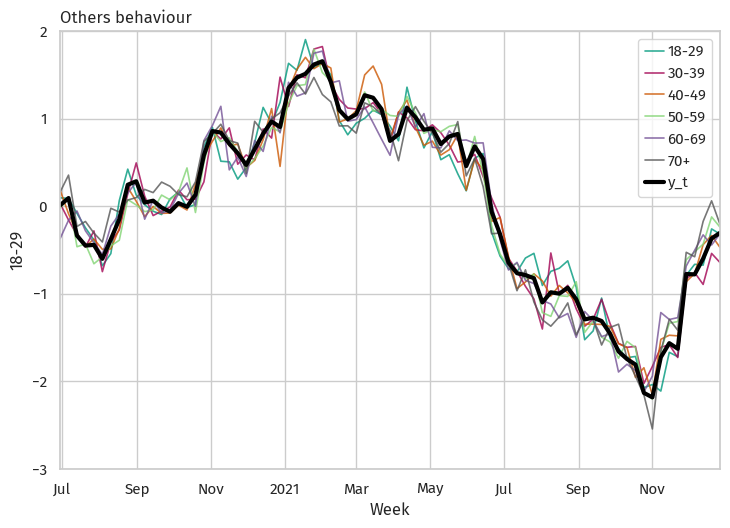

In [31]:
import pickle

def analyse_reconstruction(feature, demographic,temporal_dimension='Week'):
    temporal_dimension = temporal_dimension.capitalize()
    df_tmp = df.groupby([temporal_dimension, demographic], observed=False)[feature].mean().reset_index()
    
    _, ax = plt.subplots(figsize=(8,6))

    M = df_tmp.groupby(demographic, observed=False)[feature].mean().astype('float')
    S = df_tmp.groupby(demographic, observed=False)[feature].std().astype('float')
    Y = scale(df.groupby(temporal_dimension)[feature].mean())

    X = df_tmp.pivot(index=demographic, columns=temporal_dimension, values=feature)
    X_hat = np.matmul(S.values.reshape((-1, 1)), Y.reshape((1, -1))) + M.values.reshape((-1, 1))

    RMSE = np.sqrt(np.mean(np.square(X.values - X_hat), axis=1).astype('float'))
    MAPE = [mape(X.values[a], X_hat[a]) for a in range(X.shape[0])]
    
    days = X.columns
    
    reconstruction_timelines = {'days':days.to_numpy(), 'feature': feature}
    
    for d, demo in enumerate(df_tmp[demographic].unique()):
        this_y = (X.loc[demo] - M.iloc[d])/S.iloc[d]
        reconstruction_timelines[demo] = this_y.to_numpy()
        sns.lineplot(x=days, y=this_y, color=COLOURS[d], ax=ax, label=demo,lw=1.2,alpha=0.8)
    sns.lineplot(x=days, y=Y, color='black', ls='-', label='y_t', ax=ax,lw=3)
    plt.title(feature)
    reconstruction_timelines['Y'] = Y
    
    with open('./result_data/'+feature.replace(' ','_')+'_'+temporal_dimension+'.pickle','wb') as f:
        pickle.dump(reconstruction_timelines, f)
    

    res = pd.DataFrame.from_dict({demo: (M[demo], S[demo], RMSE[d], MAPE[d]) for d, demo in enumerate(df_tmp[demographic].unique())}, orient='index', columns=['Mean', 'Standard deviation', 'Reconstruction RMSE', 'Reconstruction MAPE'])
    res = res.style.format({'Reconstruction MAPE': '{:.2f}\%'.format}, precision=2)
    print(to_latex(res))
    
    return res

def analyse_reconstruction_contacts(feature, demographic,temporal_dimension='Week'):
    temporal_dimension = temporal_dimension.capitalize()
    df_tmp = df.groupby([temporal_dimension, demographic], observed=False)[feature].mean().reset_index()
    
    _, ax = plt.subplots(figsize=(8,6))

    M = df_tmp.groupby(demographic, observed=False)[feature].mean().astype('float')
    S = df_tmp.groupby(demographic, observed=False)[feature].std().astype('float')
    Y = scale(df.groupby(temporal_dimension)[feature].mean())

    X = df_tmp.pivot(index=demographic, columns=temporal_dimension, values=feature)
    X_hat = np.matmul(S.values.reshape((-1, 1)), Y.reshape((1, -1))) + M.values.reshape((-1, 1))

    RMSE = np.sqrt(np.mean(np.square(X.values - X_hat), axis=1).astype('float'))
    MAPE = [mape(X.values[a], X_hat[a]) for a in range(X.shape[0])]
    
    days = X.columns
    
    reconstruction_timelines = {'days':days.to_numpy(), 'feature': feature}
    
    for d, demo in enumerate(df_tmp[demographic].unique()):
        this_y = (X.loc[demo] - M.iloc[d])/S.iloc[d]
        reconstruction_timelines[demo] = this_y.to_numpy()
        sns.lineplot(x=days, y=this_y, color=COLOURS[d], ax=ax, label=demo,lw=1.2,alpha=0.8)
    sns.lineplot(x=days, y=Y, color='black', ls='-', label='y_t', ax=ax,lw=3)
    reconstruction_timelines['Y'] = Y
    
    with open('./result_data/'+feature.replace(' ','_')+'_'+temporal_dimension+'.pickle','wb') as f:
        pickle.dump(reconstruction_timelines, f)
    

    res = pd.DataFrame.from_dict({demo: (M[demo], S[demo], RMSE[d], MAPE[d]) for d, demo in enumerate(df_tmp[demographic].unique())}, orient='index', columns=['Mean', 'Standard deviation', 'Reconstruction RMSE', 'Reconstruction MAPE'])
    res = res.style.format({'Reconstruction MAPE': '{:.2f}\%'.format}, precision=2)
    
    return res

analyse_reconstruction('Others behaviour', 'Age group', 'week')

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        18-29 & 5.05 & 0.15 & 0.06 & 0.88\% \\
        30-39 & 5.17 & 0.14 & 0.05 & 0.83\% \\
        40-49 & 5.28 & 0.12 & 0.05 & 0.66\% \\
        50-59 & 5.46 & 0.10 & 0.05 & 0.81\% \\
        60-69 & 5.70 & 0.08 & 0.07 & 0.90\% \\
        70+ & 5.77 & 0.08 & 0.06 & 0.75\% \\
        \bottomrule
    \end{tabular}
    


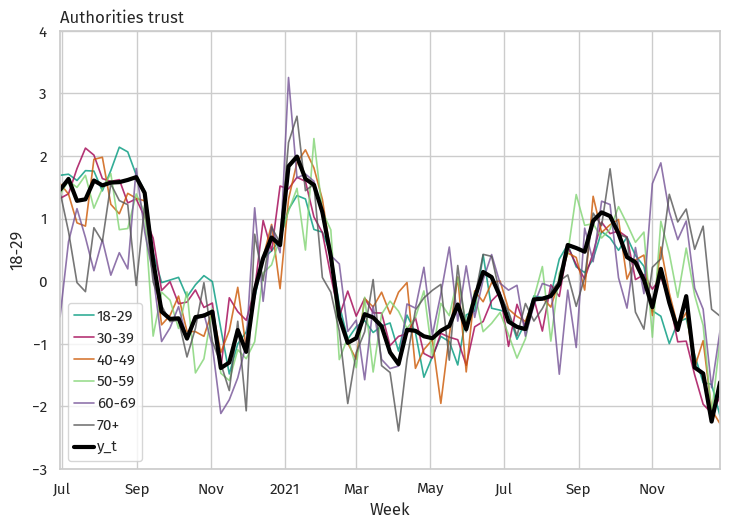

In [33]:
analyse_reconstruction('Authorities trust', 'Age group', 'Week')

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        18-29 & 4.67 & 0.36 & 0.07 & 1.10\% \\
        30-39 & 4.91 & 0.37 & 0.05 & 0.77\% \\
        40-49 & 5.04 & 0.39 & 0.04 & 0.66\% \\
        50-59 & 5.31 & 0.35 & 0.05 & 0.72\% \\
        60-69 & 5.49 & 0.34 & 0.07 & 0.97\% \\
        70+ & 5.56 & 0.34 & 0.06 & 0.92\% \\
        \bottomrule
    \end{tabular}
    


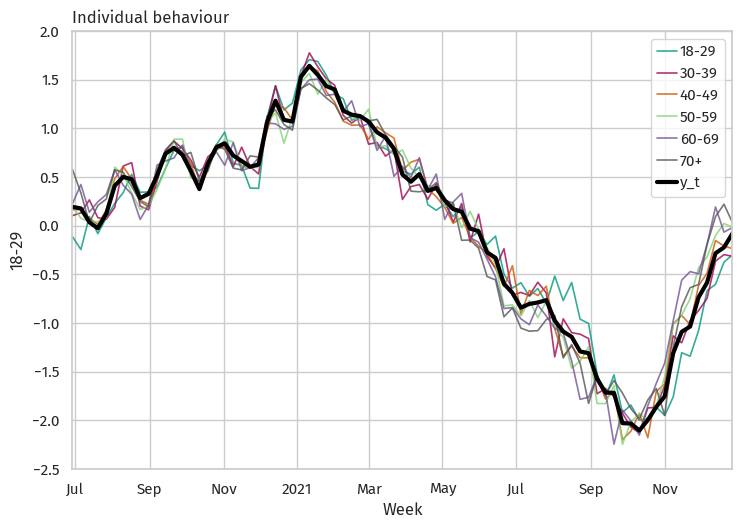

In [34]:
analyse_reconstruction('Individual behaviour', 'Age group', 'Week')

    \begin{tabular}{lrrrr}
        \toprule
         & \textbf{Mean} & \textbf{Std. Dev.} & \textbf{RMSE} & \textbf{MAPE}\\
        \midrule
        18-29 & 3.90 & 0.41 & 0.10 & 2.29\% \\
        30-39 & 3.83 & 0.42 & 0.10 & 2.37\% \\
        40-49 & 3.76 & 0.42 & 0.07 & 1.53\% \\
        50-59 & 3.67 & 0.44 & 0.06 & 1.29\% \\
        60-69 & 3.64 & 0.44 & 0.09 & 1.99\% \\
        70+ & 3.88 & 0.44 & 0.14 & 3.03\% \\
        \bottomrule
    \end{tabular}
    


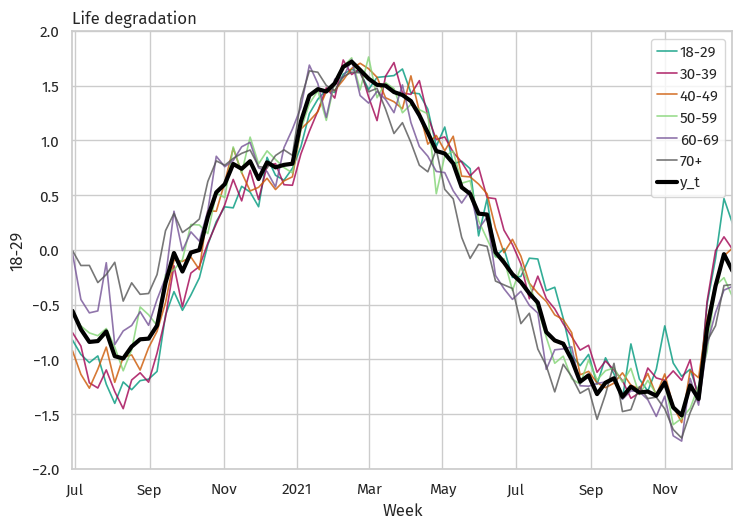

In [35]:
analyse_reconstruction('Life degradation', 'Age group','Week')

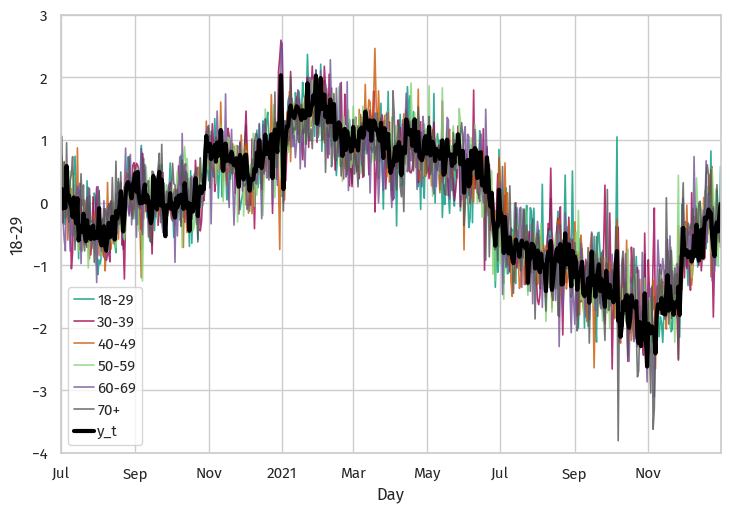

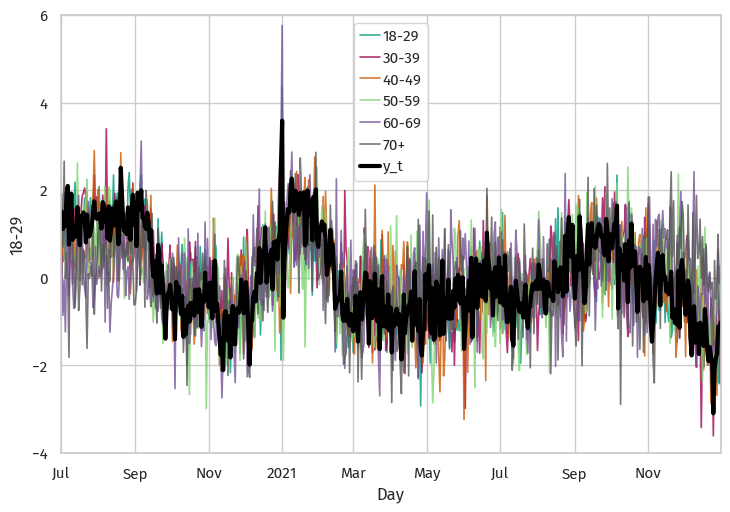

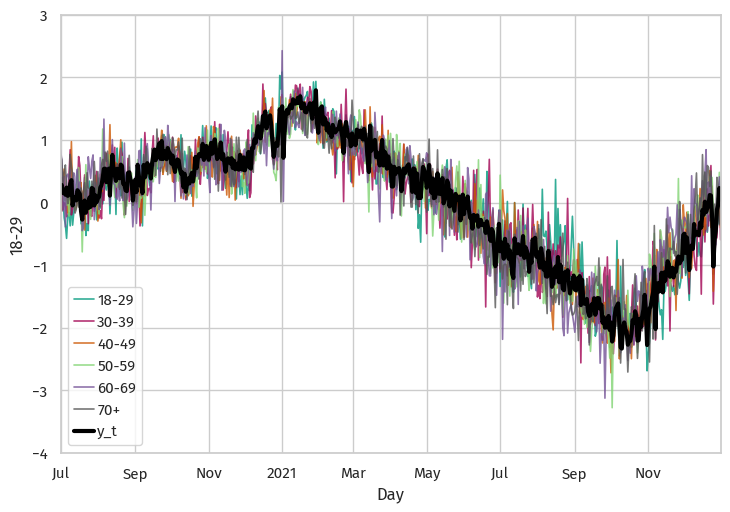

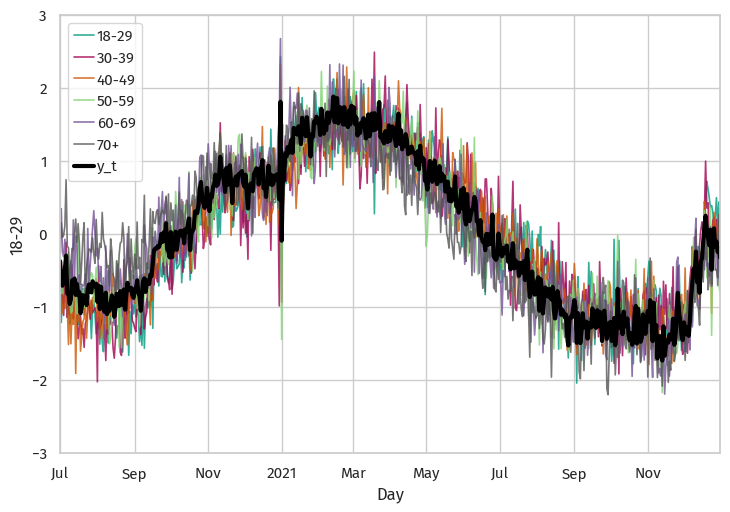

In [35]:
analyse_reconstruction('Others behaviour', 'Age group', 'day')
analyse_reconstruction('Authorities trust', 'Age group', 'day')
analyse_reconstruction('Individual behaviour', 'Age group', 'day')
analyse_reconstruction('Life degradation', 'Age group','day')

## Predicting future incidence

In [32]:
FEATURES = [
    'Others behaviour',
    'Authorities trust',
    'Individual behaviour',
    'Life degradation',
]

REGIONS = ['Hovedstaden', 'Midtjylland', 'Nordjylland', 'Sjælland', 'Syddanmark']

df_regions = df.groupby(['region', 'Day'])[FEATURES].mean()

epidata = pd.read_csv('hope_data/epidata.csv', index_col=0)
epidata['date'] = pd.to_datetime(epidata['date'])

df_regions[['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']] = \
          epidata.groupby(['region', 'date'])[
                ['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']
            ].mean()

cols = ['Others behaviour', 'Authorities trust', 'Individual behaviour', 'Life degradation'] + ['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000',]
_df = po.DataFrame(df_regions.reset_index())
stacked_df = None
for region in REGIONS:
    this_df = _df.filter(po.col('region') == region).sort(by='Day')
    for c in cols:
        this_df = this_df.with_columns([
            po.col(c).rolling_mean(7,center=True).alias(c+'_smooth')
        ])
    if stacked_df is None:
        stacked_df = this_df
    else:
        stacked_df = stacked_df.vstack(this_df)

df_regions = stacked_df.to_pandas().set_index(['region','Day'])
    


dmi = pd.read_parquet('dmi_data/dmi_daily_agg.parquet')
dmi.index = dmi.index.set_levels([pd.to_datetime(dmi.index.levels[0]), dmi.index.levels[1]])

df_regions['temperature'] = df_regions.reset_index()['Day'].map(
    dmi.loc[(slice(None), 'Temperature'),:].reset_index(1)['Average']
).values


cols = ['temperature']
_df = po.DataFrame(df_regions.reset_index())
stacked_df = None
for region in REGIONS:
    this_df = _df.filter(po.col('region') == region).sort(by='Day')
    for c in cols:
        this_df = this_df.with_columns([
            po.col(c).rolling_mean(7,center=True).alias(c+'_smooth')
        ])
    if stacked_df is None:
        stacked_df = this_df
    else:
        stacked_df = stacked_df.vstack(this_df)

df_regions = stacked_df.to_pandas().set_index(['region','Day'])



assert df_regions.reset_index()['region'].unique().to_list() == REGIONS
df_regions.head(50)

Others behaviour  Authorities trust  Individual behaviour  Life degradation  cases_per_100000  hospit_per_100000  deaths_per_100000  proportion_second_dose  Others behaviour_smooth  Authorities trust_smooth  Individual behaviour_smooth  Life degradation_smooth  cases_per_100000_smooth  hospit_per_100000_smooth  deaths_per_100000_smooth  temperature  temperature_smooth
region      Day                                                                                                                                                                                                                                                                                                                                                                                           
Hovedstaden 2020-07-01          4.788578           5.582487              5.173243          3.724138          0.323435           0.053906           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    15.891924                 NaN
            2020-07-02          4.886253           5.468370              5.228305          3.537713          0.754683           0.107812           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    15.423255                 NaN
            2020-07-03          4.723958           5.468387              5.117225          3.497758          0.592965           0.000000           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    14.130059                 NaN
            2020-07-04          4.680172           5.521709              5.087835          3.612069          0.539059           0.000000           0.053906                     0.0                 4.746689                  5.507204                     5.133508                 3.592095                 0.485153                  0.046205              2.310253e-02    15.409970           14.808606
            2020-07-05          4.734884           5.516348              5.102961          3.726098          0.431247           0.053906           0.000000                     0.0                 4.748259                  5.496079                     5.127495                 3.545915                 0.585264                  0.038504              2.310253e-02    16.196792           14.380028
            2020-07-06          4.785294           5.516289              5.074444          3.483333          0.269530           0.053906           0.107812                     0.0                 4.749800                  5.512128                     5.129047                 3.537319                 0.646871                  0.030803              2.310253e-02    13.735930           14.044699
            2020-07-07          4.627684           5.476840              5.150541          3.563559          0.485153           0.053906           0.000000                     0.0                 4.731905                  5.522186                     5.138259                 3.528397                 0.739281                  0.038504              3.080338e-02    12.872314           13.804766
            2020-07-08          4.799564           5.504614              5.131155          3.400871          1.024212           0.000000           0.000000                     0.0                 4.766721                  5.527089                     5.156361                 3.524510                 0.816290                  0.069308              2.310253e-02    12.891877           13.570409
            2020-07-09          4.897045           5.580713              5

In [33]:
po.DataFrame(epidata).sort('date').head(200)

shape: (200, 22)
┌───────────┬───────────┬───────┬────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ date      ┆ region    ┆ cases ┆ hospit ┆ ... ┆ vaccine_fi ┆ vaccine_se ┆ proportion ┆ proportion │
│ ---       ┆ ---       ┆ ---   ┆ ---    ┆     ┆ rst_dose   ┆ cond_dose  ┆ _first_dos ┆ _second_do │
│ datetime[ ┆ str       ┆ i64   ┆ i64    ┆     ┆ ---        ┆ ---        ┆ e          ┆ se         │
│ ns]       ┆           ┆       ┆        ┆     ┆ i64        ┆ i64        ┆ ---        ┆ ---        │
│           ┆           ┆       ┆        ┆     ┆            ┆            ┆ f64        ┆ f64        │
╞═══════════╪═══════════╪═══════╪════════╪═════╪════════════╪════════════╪════════════╪════════════╡
│ 2020-02-2 ┆ Hovedstad ┆ 0     ┆ 0      ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 6         ┆ en        ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-02-2 ┆ Midtjylla ┆ 0     ┆ 0      ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 6         ┆ nd        ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-02-2 ┆ Nordjylla ┆ 0     ┆ 0      ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 6         ┆ nd        ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-02-2 ┆ Syddanmar ┆ 0     ┆ 0      ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 6         ┆ k         ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...       ┆ ...       ┆ ...   ┆ ...    ┆ ... ┆ ...        ┆ ...        ┆ ...        ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-03-2 ┆ Sjælland  ┆ 15    ┆ 9      ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 9         ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-03-2 ┆ Danmark   ┆ 254   ┆ 102    ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 9         ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-03-3 ┆ Hovedstad ┆ 161   ┆ 39     ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 0         ┆ en        ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2020-03-3 ┆ Midtjylla ┆ 41    ┆ 11     ┆ ... ┆ 0          ┆ 0          ┆ 0.0        ┆ 0.0        │
│ 0         ┆ nd        ┆       ┆        ┆     ┆            ┆            ┆            ┆            │
│ 00:00:00  ┆           ┆       ┆        ┆  

In [34]:
REGIONS

['Hovedstaden', 'Midtjylland', 'Nordjylland', 'Sjælland', 'Syddanmark']

In [35]:
df_regions['Estimated # contacts'] = np.array([None]*len(df_regions), dtype=np.double)

pd_df = df

for region in REGIONS:
    this_df = po.DataFrame(df[df['region'] == region])

    days = this_df['Day'].cast(po.Date).to_numpy()
    contacts = this_df['# contacts'].to_numpy()
    intdays = (days-days[0])
    intdays = intdays.astype(int)
    unique_int_days = np.sort(np.unique(intdays))
    unique_days = days[0] + unique_int_days.astype(np.timedelta64(1,'D'))

    unique_weeks = this_df['Week'].unique().sort()

    be = np.logspace(1,5,101)
    be = np.concatenate([np.arange(1,10), be])

    mus, sigmas = [], []
    means = []
    medians = []
    contact_numbers = []
    
    for j in tqdm(range(3,len(unique_int_days)-3)):
        ndx = np.where(np.logical_and(intdays>=j-3,intdays<=j+3))[0]
        Ncont = contacts[ndx]
        N0 = np.count_nonzero(Ncont == 0.0)
        Ncont = Ncont[np.logical_and(Ncont>0,Ncont<1e6)]
        p0 = N0 / (N0 + len(Ncont))

        data = Ncont

        mu, sigma = lognormal.mu_and_sigma(data)

        mean = (1-p0) * np.exp(mu + sigma**2/2)
        variance = (1-p0) * (np.exp(sigma**2)-1) * np.exp(2*mu+sigma**2)
        k2 = variance + mean**2
        contact_number = k2/mean
        
        #print(p0)
        
        if p0 > 0.5:
            median = 0
        else:
            q = (0.5-p0)/(1-p0)
            median = np.exp(mu + sigma*np.sqrt(2)*erfinv(2*q-1))
            
        means.append(mean)
        contact_numbers.append(contact_number)
        medians.append(median)
        


    plotdays = unique_days[3:-3]


    df_regions.loc[region].iloc[3:-3].loc[:, 'Estimated # contacts'] = medians
     
df_regions.head()

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

Others behaviour  Authorities trust  Individual behaviour  Life degradation  cases_per_100000  hospit_per_100000  deaths_per_100000  proportion_second_dose  Others behaviour_smooth  Authorities trust_smooth  Individual behaviour_smooth  Life degradation_smooth  cases_per_100000_smooth  hospit_per_100000_smooth  deaths_per_100000_smooth  temperature  temperature_smooth  Estimated # contacts
region      Day                                                                                                                                                                                                                                                                                                                                                                                                                 
Hovedstaden 2020-07-01          4.788578           5.582487              5.173243          3.724138          0.323435           0.053906           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    15.891924                 NaN                   NaN
            2020-07-02          4.886253           5.468370              5.228305          3.537713          0.754683           0.107812           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    15.423255                 NaN                   NaN
            2020-07-03          4.723958           5.468387              5.117225          3.497758          0.592965           0.000000           0.000000                     0.0                      NaN                       NaN                          NaN                      NaN                      NaN                       NaN                       NaN    14.130059                 NaN                   NaN
            2020-07-04          4.680172           5.521709              5.087835          3.612069          0.539059           0.000000           0.053906                     0.0                 4.746689                  5.507204                     5.133508                 3.592095                 0.485153                  0.046205                  0.023103    15.409970           14.808606              5.903610
            2020-07-05          4.734884           5.516348              5.102961          3.726098          0.431247           0.053906           0.000000                     0.0                 4.748259                  5.496079                     5.127495                 3.545915                 0.585264                  0.038504                  0.023103    16.196792           14.380028              5.858901

In [36]:
#dfreg = po.from_pandas(df_regions.reset_index(names=['region', 'Day']))
#dfreg
df_regions.to_csv('result_data/regions_with_temperature.csv')

### Model

In [37]:
# Define the Time series model
class TimeSeriesRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=16, model='gru'):
        super().__init__()
        
        if model == 'gru':
            self.ts = nn.GRU(input_size, hidden_size, batch_first=True) 
        elif model == 'lstm':
            self.ts = nn.LSTM(input_size, hidden_size, batch_first=True)
        else:
            return ValueError(f'Model {model} is not valid, must be one of `gru`, `lstm`')
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.ts(x.float())
        return self.fc(out[:, -1, :])
    
    def fit(self, X_train, y_train, lr=1e-3, wd=1e-3, bs=32, epochs=20):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        
        X_train = torch.from_numpy(X_train).float()
        y_train = torch.from_numpy(y_train).float()
        
        self.train()
        for epoch in range(epochs):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], bs):
                indices = permutation[i:i+bs]
                batch_X, batch_y = X_train[indices], y_train[indices]
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
        return self
    
    def predict(self, X_test):
        X_test = torch.from_numpy(X_test).float()
        
        self.eval()
        return self(X_test).detach().numpy()

### Preparing data

In [38]:
PAST   = 7
FUTURE = 14
N_TIMES = 20

EPOCHS = 50
LR = 1e-2
WD = 1e-4
HIDDEN_SIZE = 32
MODEL = 'lstm'

SURVEY_FEATURES = [f + '_smooth' for f in FEATURES] + ['Estimated # contacts']
OTHER_FEATURES = ['temperature_smooth', 'proportion_second_dose', 'hospit_per_100000_smooth', 'deaths_per_100000_smooth', 'cases_per_100000_smooth']

X = {region: list() for region in REGIONS}
X_no_survey = {region: list() for region in REGIONS}
y = {region: list() for region in REGIONS}
y_today = {region: list() for region in REGIONS}
dates = {region: list() for region in REGIONS}
dates_today = {region: list() for region in REGIONS}


for region in REGIONS:
    df_X = df_regions.loc[region].dropna().copy()
    df_X = df_X.astype('float')
    
    df_X = df_X[SURVEY_FEATURES + OTHER_FEATURES]
    
    for i in range(len(df_X) - PAST - FUTURE):
        X[region].append(df_X.iloc[i:i+PAST])
        X_no_survey[region].append(df_X[OTHER_FEATURES].iloc[i:i+PAST])
        y[region].append(df_X.iloc[i+PAST:i+PAST+FUTURE, -1])
        y_today[region].append(df_X.iloc[i+PAST-1,-1])
        dates[region].append(df_X.index[i+PAST])
        dates_today[region].append(df_X.index[i+PAST-1])
        
    dates_today[region] = np.array(dates_today[region])
    y_today[region] = np.array(y_today[region])

In [39]:
res = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
med = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
std = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
res_mape = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
std_mape = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
res_rmsre = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
std_rmsre = {region: pd.DataFrame(columns=[f'T+{i}' for i in range(FUTURE)]) for region in REGIONS}
forecast_wo_survey = {}
forecast_full = {}

### Baseline

In [40]:
for test_region in tqdm(REGIONS):
    results = []
    results_mape = []
    results_rmsre = []
    
    # Run test
    train_regions = [region for region in REGIONS if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])
    
    results.append([
        np.sqrt(
            mean_squared_error(
                y_test[:,t], 
                X_test[:,-1:,-1]
            )
        )
    for t in range(FUTURE)])
    
    results_mape.append([
        mean_absolute_percentage_error(
            y_test[:,t], 
            X_test[:,-1:,-1]
        )
    for t in range(FUTURE)])

    results_rmsre.append([
            np.sqrt(
                np.mean(
                   ( (y_test[:,t] - X_test[:,-1:,-1]) / y_test[:,t] )**2
                )
            )
    for t in range(FUTURE)])

    
    res[test_region].loc['Baseline'] = np.array(results).mean(axis=0)
    std[test_region].loc['Baseline'] = np.array(results).std(axis=0)
    res_mape[test_region].loc['Baseline'] = np.array(results_mape).mean(axis=0)
    std_mape[test_region].loc['Baseline'] = np.array(results_mape).std(axis=0)
    res_rmsre[test_region].loc['Baseline'] = np.array(results_rmsre).mean(axis=0)
    std_rmsre[test_region].loc['Baseline'] = np.array(results_rmsre).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

### Model without survey

In [45]:

for test_region in tqdm(REGIONS):
    
    results = []
    results_mape = []
    results_rmsre = []
    
    forecast = []
    
    # Run test
    train_regions = [region for region in REGIONS if region != test_region]
    X_train = np.vstack([v for k, v in X_no_survey.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X_no_survey[test_region])
    y_test = np.array(y[test_region])
        
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))

    truth = y_test[:,0]
    
    for seed in range(N_TIMES):
        torch.manual_seed(2020 + seed)
        
        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=MODEL, hidden_size=HIDDEN_SIZE)\
                                   .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)
        y_pred = model.predict(X_test)
 
        results.append([
            np.sqrt(
                mean_squared_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
            )
        for t in range(FUTURE)])
        
        results_mape.append([
                mean_absolute_percentage_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
        for t in range(FUTURE)])

        results_rmsre.append([
            np.sqrt(
                np.mean(
                   ( (y_test[:,t] - y_pred[:,t]) / y_test[:,t] )**2
                )
            )
        for t in range(FUTURE)])

        forecast.append(y_pred)

    forecast_mean = np.array(forecast).mean(axis=0)
    forecast_std = np.array(forecast).std(axis=0)
    forecast_wo_survey[test_region] = {'forecast_mean':forecast_mean, 'forecast_std': forecast_std}
    
    res[test_region].loc['LSTM w/o survey'] = np.array(results).mean(axis=0)
    std[test_region].loc['LSTM w/o survey'] = np.array(results).std(axis=0)
    res_mape[test_region].loc['LSTM w/o survey'] = np.array(results_mape).mean(axis=0)
    std_mape[test_region].loc['LSTM w/o survey'] = np.array(results_mape).std(axis=0)
    res_rmsre[test_region].loc['LSTM w/o survey'] = np.array(results_rmsre).mean(axis=0)
    std_rmsre[test_region].loc['LSTM w/o survey'] = np.array(results_rmsre).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

### Model with survey

In [46]:
for test_region in tqdm(REGIONS):
    
    results = []
    results_mape = []
    results_rmsre = []

    forecast = []

    # Run test
    train_regions = [region for region in REGIONS if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])
        
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    
    truth = y_test[:,0]
 
    for seed in range(N_TIMES):
        torch.manual_seed(2020 + seed)
        
        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, model=MODEL, hidden_size=HIDDEN_SIZE)\
                                   .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)
        y_pred = model.predict(X_test)

        results.append([
            np.sqrt(
                mean_squared_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
            )
        for t in range(FUTURE)])

        results_mape.append([
                mean_absolute_percentage_error(
                    y_test[:,t], 
                    y_pred[:,t]
                )
        for t in range(FUTURE)])

        results_rmsre.append([
            np.sqrt(
                np.mean(
                   ( (y_test[:,t] - y_pred[:,t]) / y_test[:,t] )**2
                )
            )
        for t in range(FUTURE)])


        forecast.append(y_pred)

    forecast_mean = np.array(forecast).mean(axis=0)
    forecast_std = np.array(forecast).std(axis=0)
    forecast_full[test_region] = {'forecast_mean':forecast_mean, 'forecast_std': forecast_std}
    
    
    res[test_region].loc['LSTM'] = np.array(results).mean(axis=0)
    std[test_region].loc['LSTM'] = np.array(results).std(axis=0)
    res_mape[test_region].loc['LSTM'] = np.array(results_mape).mean(axis=0)
    std_mape[test_region].loc['LSTM'] = np.array(results_mape).std(axis=0)
    res_rmsre[test_region].loc['LSTM'] = np.array(results_rmsre).mean(axis=0)
    std_rmsre[test_region].loc['LSTM'] = np.array(results_rmsre).std(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

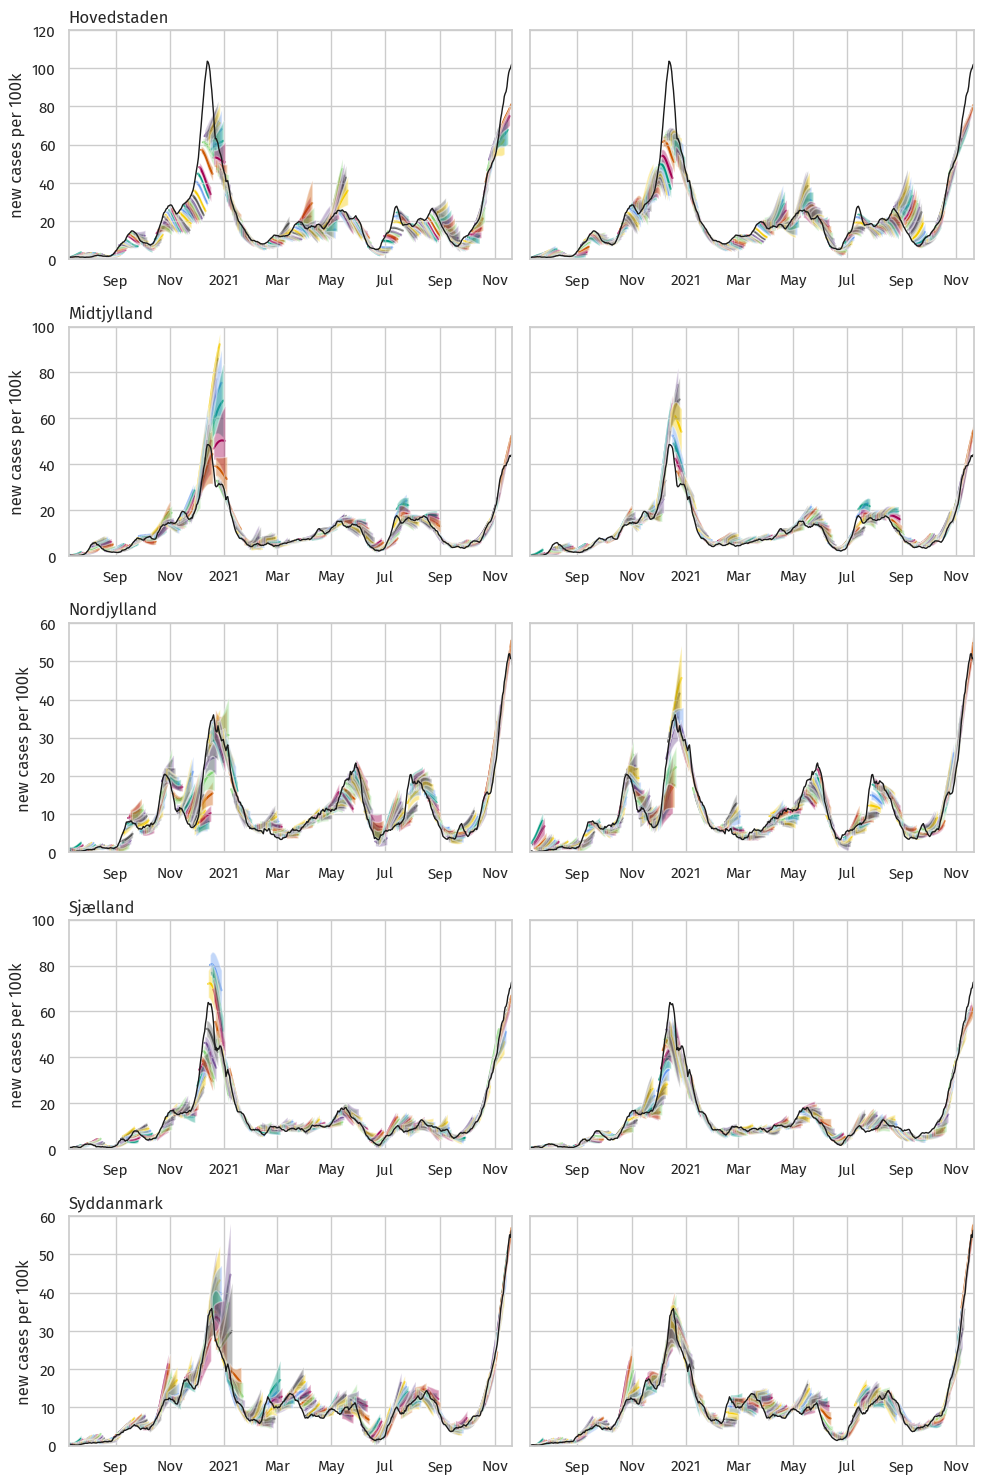

In [47]:

fig, ax = plt.subplots(5,2,figsize=(10,15),sharey='row')
for i, test_region in enumerate(REGIONS):
    for j, _forecast in enumerate([forecast_wo_survey, forecast_full]):
        
        fc = _forecast[test_region]
        ax[i,j].plot(dates_today[test_region], y_today[test_region],lw=1,c='k')
        _mean = fc['forecast_mean']
        _std = fc['forecast_std']
        for t in range(0,_mean.shape[0]-FUTURE,2):
            _x = dates_today[test_region][np.arange(t+1, t+1+FUTURE)]
            handle, = ax[i,j].plot(_x, _mean[t, :],zorder=-1000)
            ax[i,j].fill_between(_x, _mean[t,:]- _std[t,:],_mean[t,:]+ _std[t,:],alpha=0.4,
                             fc=handle.get_color(),)
        ax[i,j].set_ylim(0,ax[i,j].get_ylim()[-1])
    ax[i,0].set_title(test_region)
    ax[i,0].set_ylabel('new cases per 100k')
fig.tight_layout()
#plt.yscale('log')

In [48]:
if False:
    with open('result_data/model_results_for_smoothed_data.pickle','rb') as f:
        _data = pickle.load(f)
        res = _data['res']
        med = _data['med']
        std = _data['std']

### Results

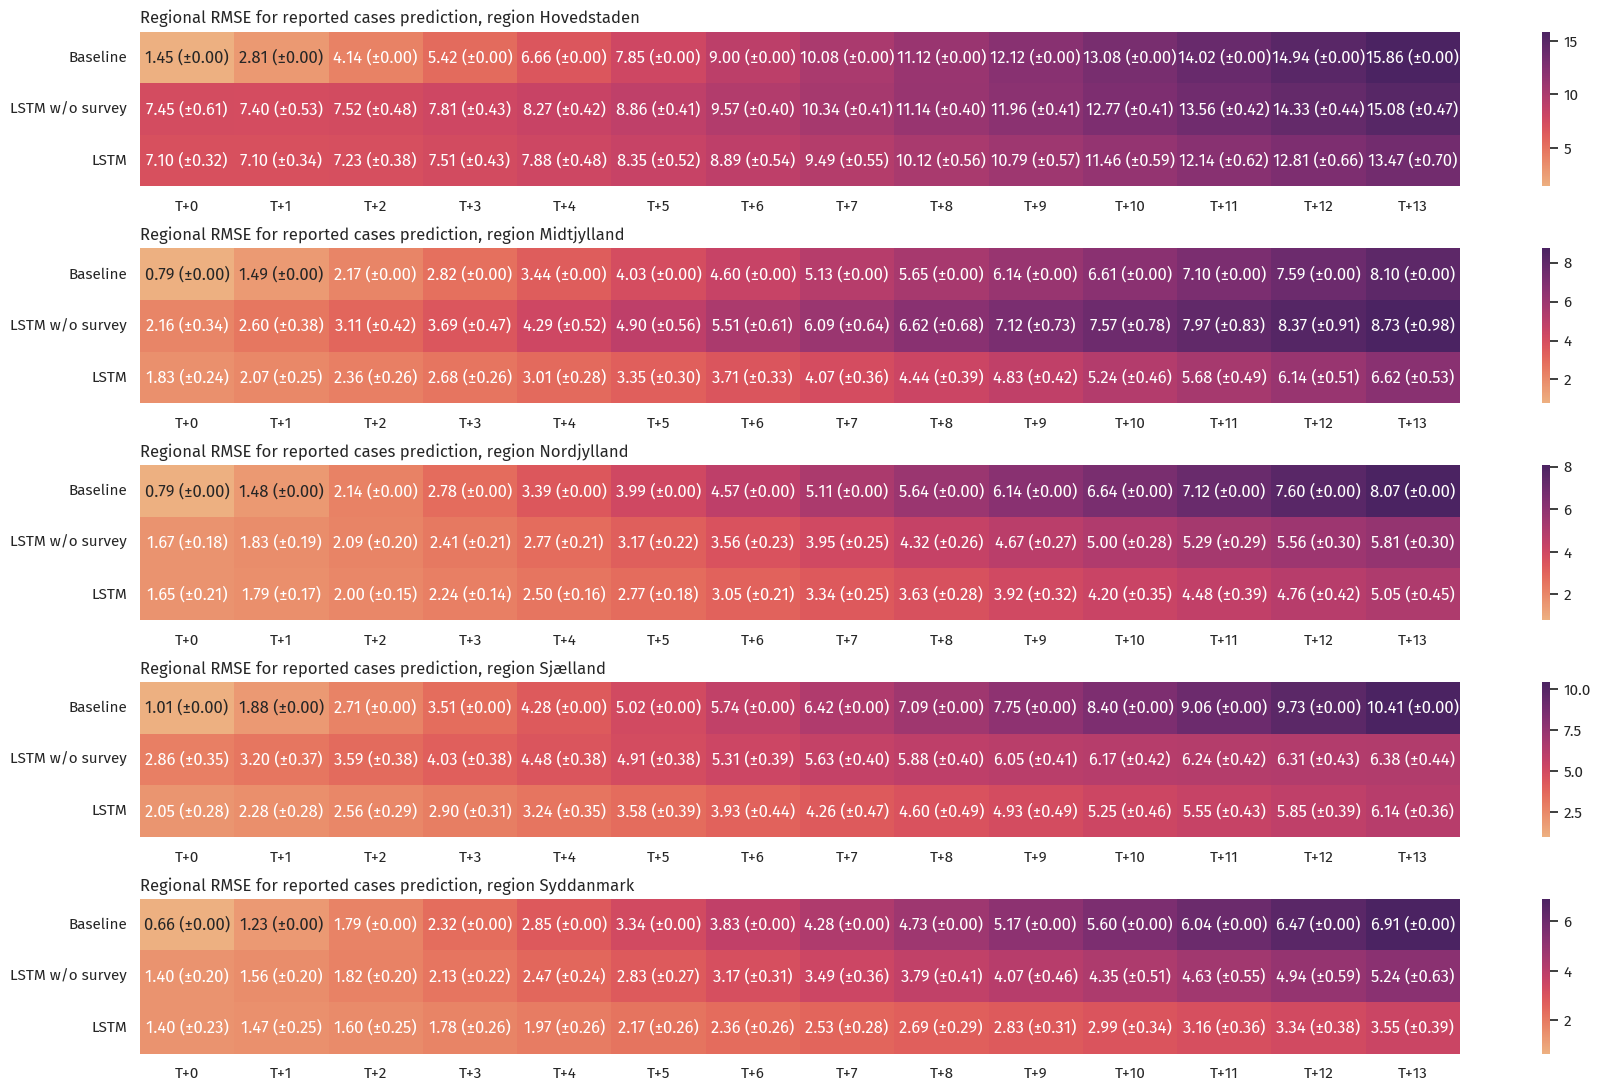

In [49]:
def get_str(avg, std):
    out = list()
    
    for i in range(avg.shape[0]):
        out.append(list())
        for j in range(avg.shape[1]):
            out[-1].append(f'{avg.iloc[i, j]:.2f} (±{std.iloc[i, j]:.2f})')
            
    return out

fig, axs = plt.subplots(5, 1, figsize=(20,14))

for r, region in enumerate(REGIONS):
    annots = get_str(res[region], std[region])
    sns.heatmap(res[region], annot=annots, fmt='', cmap='flare', ax=axs[r]).set(title=f'Regional RMSE for reported cases prediction, region {region}')

fig.subplots_adjust(hspace=0.40)
plt.savefig('figures/paper/loo_prediction_rmse.png', bbox_inches='tight', pad_inches=0., dpi=500)

with open('result_data/model_results_for_smoothed_data.pickle','wb') as f:
    pickle.dump({'res':res,'med':med,'std':std,
                 'res_mape':res_mape,'std_mape':std_mape,
                 'res_rmrse':res_rmsre,'std_rmsre':std_rmsre,
                 'forecast_wo_survey': forecast_wo_survey,
                 'forecast_full': forecast_full,
                 'y_today': y_today,
                 'dates_today': dates_today,
                },f)

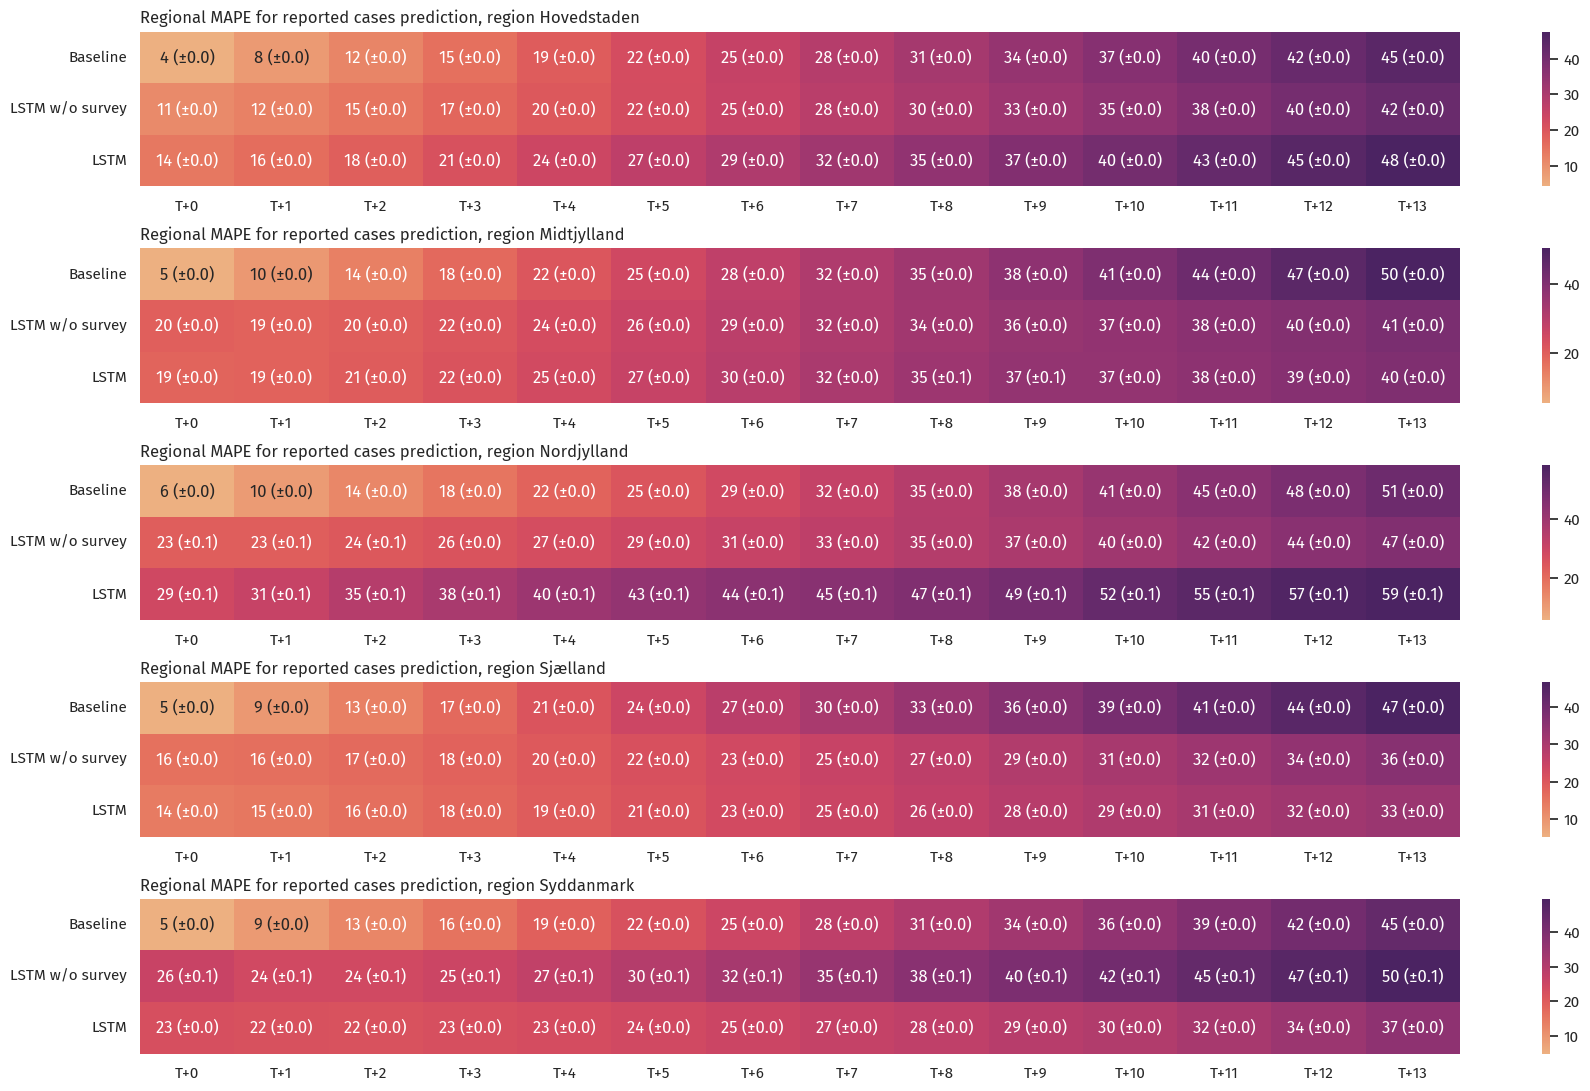

In [50]:
def get_str(avg, std):
    out = list()
    
    for i in range(avg.shape[0]):
        out.append(list())
        for j in range(avg.shape[1]):
            out[-1].append(f'{avg.iloc[i, j]:.0f} (±{std.iloc[i, j]:.1f})')
            
    return out

fig, axs = plt.subplots(5, 1, figsize=(20,14))

for r, region in enumerate(REGIONS):
    annots = get_str(res_mape[region]*100, std_mape[region])
    sns.heatmap(res_mape[region]*100, annot=annots, fmt='', cmap='flare', ax=axs[r]).set(title=f'Regional MAPE for reported cases prediction, region {region}')

fig.subplots_adjust(hspace=0.40)
plt.savefig('figures/paper/loo_prediction_mape.png', bbox_inches='tight', pad_inches=0., dpi=500)


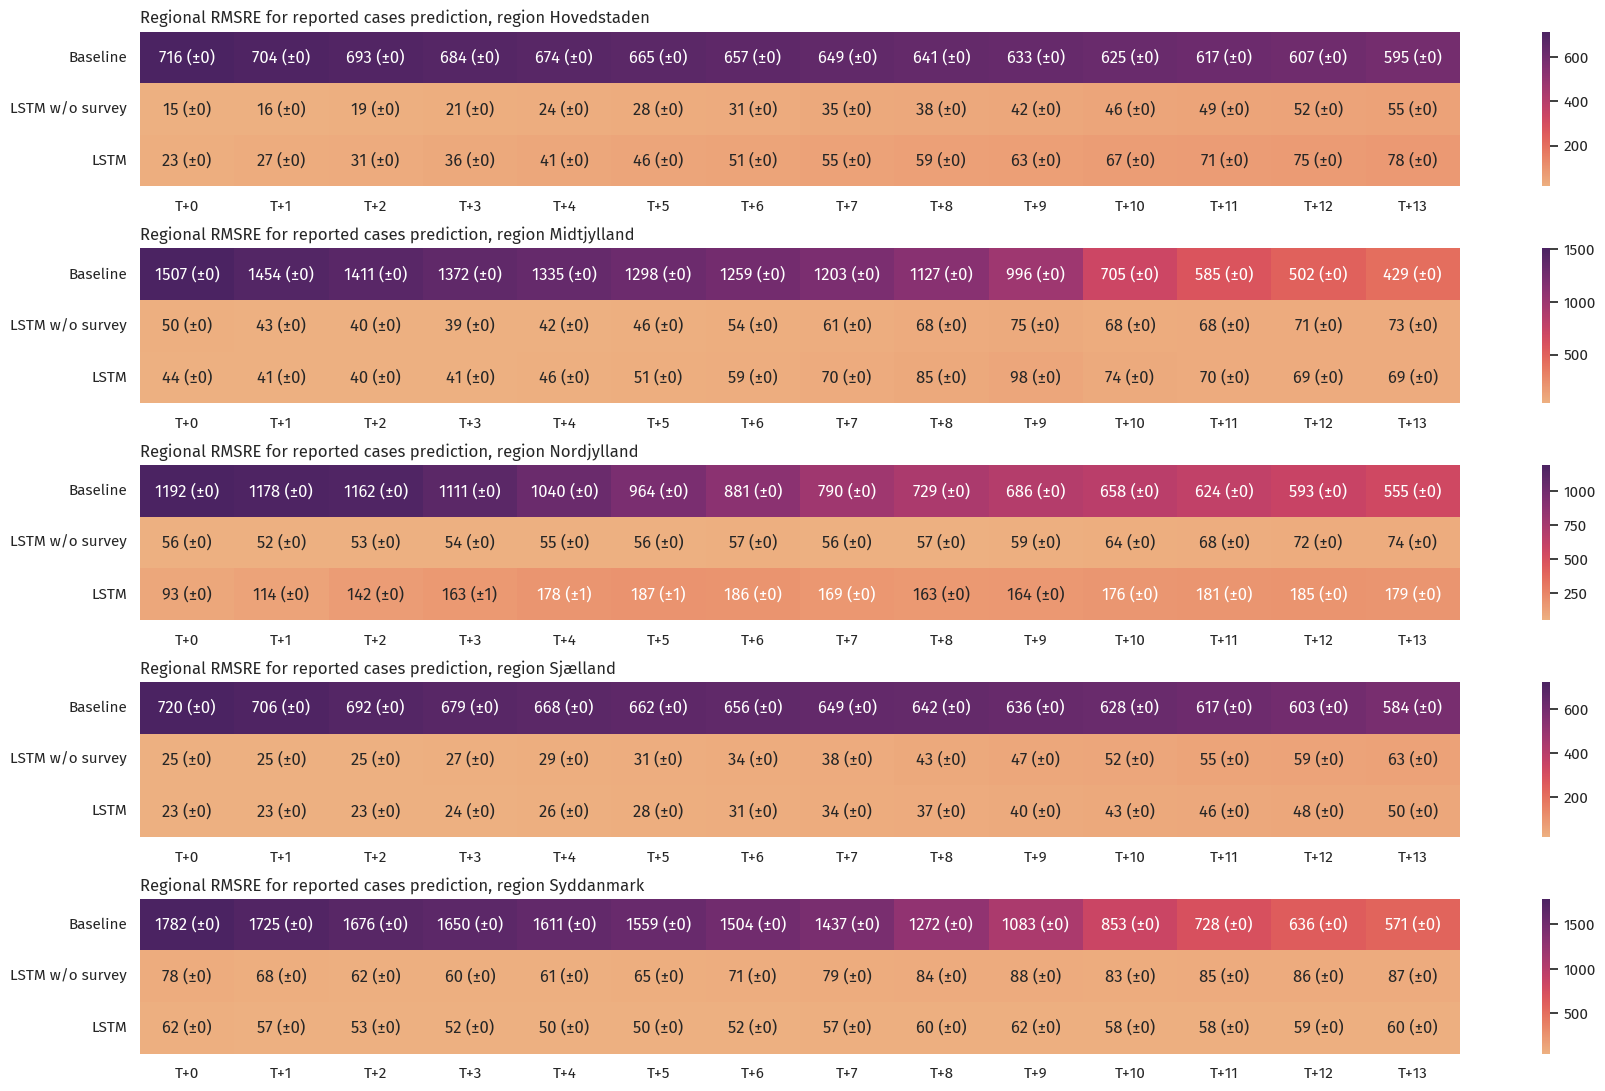

In [51]:
def get_str(avg, std):
    out = list()
    
    for i in range(avg.shape[0]):
        out.append(list())
        for j in range(avg.shape[1]):
            out[-1].append(f'{avg.iloc[i, j]:.0f} (±{std.iloc[i, j]:.0f})')
            
    return out

fig, axs = plt.subplots(5, 1, figsize=(20,14))

for r, region in enumerate(REGIONS):
    annots = get_str(res_rmsre[region]*100, std_rmsre[region])
    sns.heatmap(res_rmsre[region]*100, annot=annots, fmt='', cmap='flare', ax=axs[r]).set(title=f'Regional RMSRE for reported cases prediction, region {region}')

fig.subplots_adjust(hspace=0.40)
plt.savefig('figures/paper/loo_prediction_rmsre.png', bbox_inches='tight', pad_inches=0., dpi=500)


### Explaining results

In [41]:
if True:
    _data = np.load('result_data/explanations_integrated_gradients_for_all_smoothed_data__unnorm.npz',allow_pickle=True)
    #_data = _data['arr_0'].tolist()
    explanations = _data['explanations']
    integrated_gradients = _data['integrated_gradients']
else:
    test_region = 'Midtjylland'
    eps = 1e-3
    bias_factor = 0.

    preds = pd.DataFrame(columns=['Date', 'Predicted R(t)'])

    train_regions = [region for region in REGIONS if region != test_region]
    X_train = np.vstack([v for k, v in X.items() if k in train_regions])
    y_train = np.vstack([v for k, v in y.items() if k in train_regions])
    X_test = np.array(X[test_region])
    y_test = np.array(y[test_region])

    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))

    N_TIMES = 200
    explanations = list()
    integrated_gradients = list()

    for i in trange(N_TIMES):
        torch.manual_seed(2020 + i)

        model = TimeSeriesRegressor(X_train.shape[-1], FUTURE, hidden_size=HIDDEN_SIZE, model=MODEL)\
                                   .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)

        y_pred = model.predict(X_test)

        for j in range(y_pred.shape[0]):
            preds.loc[len(preds)] = (dates[test_region][j], y_pred[j][0])

        W = [p for p in model.parameters()]

        W_t = list()
        W_t.append(W[0].T.detach().numpy())
        W_t.append(W[1].T.detach().numpy())
        W_t.append((W[2] + W[3]).detach().numpy())
        W_t.append(np.zeros_like(W_t[0]))
        W_t.append(np.zeros_like(W_t[1]))
        W_t.append(np.zeros_like(W_t[2]))
        W_t.append(
            np.vstack((
                W[4].T.detach().numpy(),
                np.zeros_like(W[4].T.detach().numpy())
            ))
        )
        W_t.append(W[5].detach().numpy() )

        lstm_expl = LSTM_network(HIDDEN_SIZE, X_train.shape[2], FUTURE, W_t)
        lstm_expl, _ = lstm_expl.lrp(np.array(X[test_region]), y=np.ones(len(X[test_region])) * (FUTURE-1), eps=eps, bias_factor=bias_factor)
        lstm_expl = lstm_expl.numpy().mean(axis=0).T
        #lstm_expl /= np.max(np.abs(lstm_expl))
        explanations.append(lstm_expl)

        ig = IntegratedGradients(model)
        lstm_ig = ig.attribute(torch.from_numpy(np.array(X[test_region])), target=torch.from_numpy(np.ones(len(X[test_region]), dtype=np.int64) * (FUTURE-1)), n_steps=200)
        lstm_ig = lstm_ig.numpy().mean(axis=0).T
        #lstm_ig /= np.max(np.abs(lstm_ig))
        integrated_gradients.append(lstm_ig)

    explanations = np.array(explanations)
    
    np.savez('result_data/explanations_integrated_gradients_for_all_smoothed_data__unnorm.npz',
         **{'explanations':explanations,
            'integrated_gradients':np.array(integrated_gradients),
           })

In [42]:
# Sample data for demonstration
# Assume we have 5 samples, 3 categories, and 7 days
def boxplots(arr, categories):

    # Prepare data for plotting
    data_for_plotting = []
    labels = []
    days = arr.shape[-1]

    for category, label in enumerate(categories):
        for day in range(days):
            # Extract data for each (category, day) combination across samples
            data_for_plotting.append(arr[:, category, day])
            labels.append(f"{label} - T{-6+day if -6+day< 0 else '   '}")
                
    # Plotting the boxplots with colors by category
    fig, ax = plt.subplots(figsize=(10, len(categories )*1.5))
    box = plt.boxplot(data_for_plotting[::-1], vert=False, patch_artist=True,
                      flierprops=dict(marker='.'),
                    medianprops=dict(color='w')

                      #,showfliers=False
                     )

    # Apply colors by category to box plots
    for i, patch in enumerate(box['boxes']):
        category_idx = i // days
        patch.set_facecolor(COLOURS[category_idx % len(COLOURS)])
        box['fliers'][i].set_markeredgecolor('grey')
        box['fliers'][i].set_markerfacecolor(COLOURS[category_idx % len(COLOURS)])
    
    plt.yticks(range(1, len(labels) + 1), labels[::-1])
    fig.tight_layout()
    return plt.gca()


Explanation using LRP:
-0.61  +0.59  +1.00  +1.54  +3.78  --  Cases / 100k
-3.81  -1.02  -0.56  -0.24  +0.34  --  Average national temperature
-2.96  -0.72  -0.39  -0.20  +0.18  --  Others' compliance
-0.26  +0.12  +0.29  +0.59  +2.11  --  Estimated # contacts
-2.31  -0.53  -0.24  -0.07  +0.42  --  Individual compliance
-0.64  -0.10  +0.04  +0.16  +0.77  --  Life degradation
-0.05  +0.00  +0.02  +0.05  +0.24  --  Hospitalisations / 100k
-1.16  -0.21  -0.01  +0.20  +1.57  --  Authorities trust
-0.01  -0.00  +0.00  +0.01  +0.04  --  Deaths / 100k
-0.03  -0.01  +0.00  +0.01  +0.04  --  Proportion of vaccinated

    \begin{tabular}{rrrrrr}
        \toprule
             & \textbf{Q2.5} & \textbf{Q25} & \textbf{Median} & \textbf{Q75} & \textbf{Q97.5} \\
        \midrule
            Cases / 100k & -0.61 & 0.59 & 1.00 & 1.54 & 3.78\\
            Average national temperature & -3.81 & -1.02 & -0.56 & -0.24 & 0.34\\
            Others' compliance & -2.96 & -0.72 & -0.39 & -0.20 & 0.18\\
        

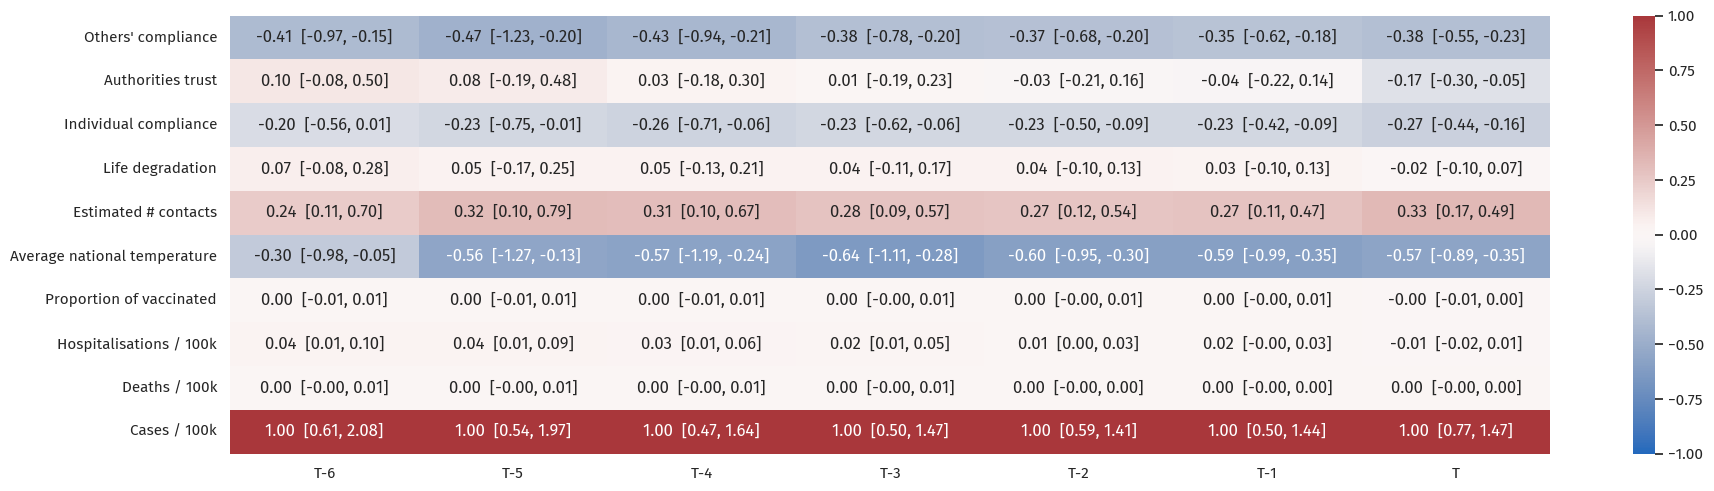

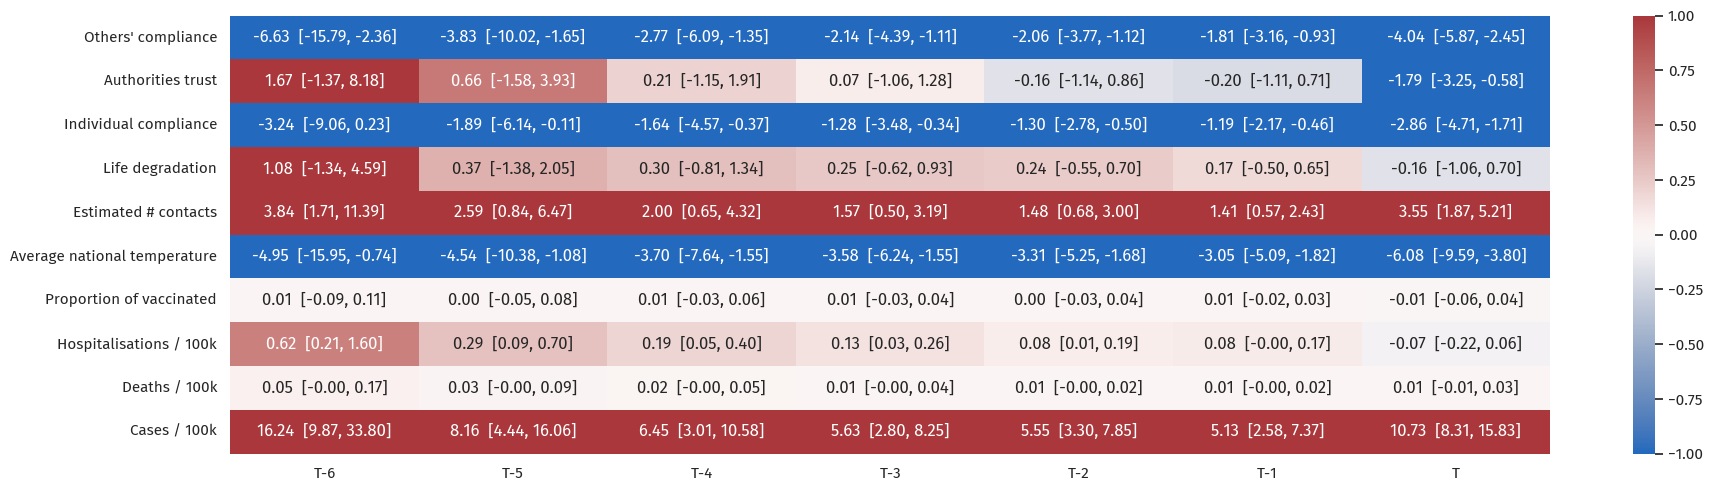

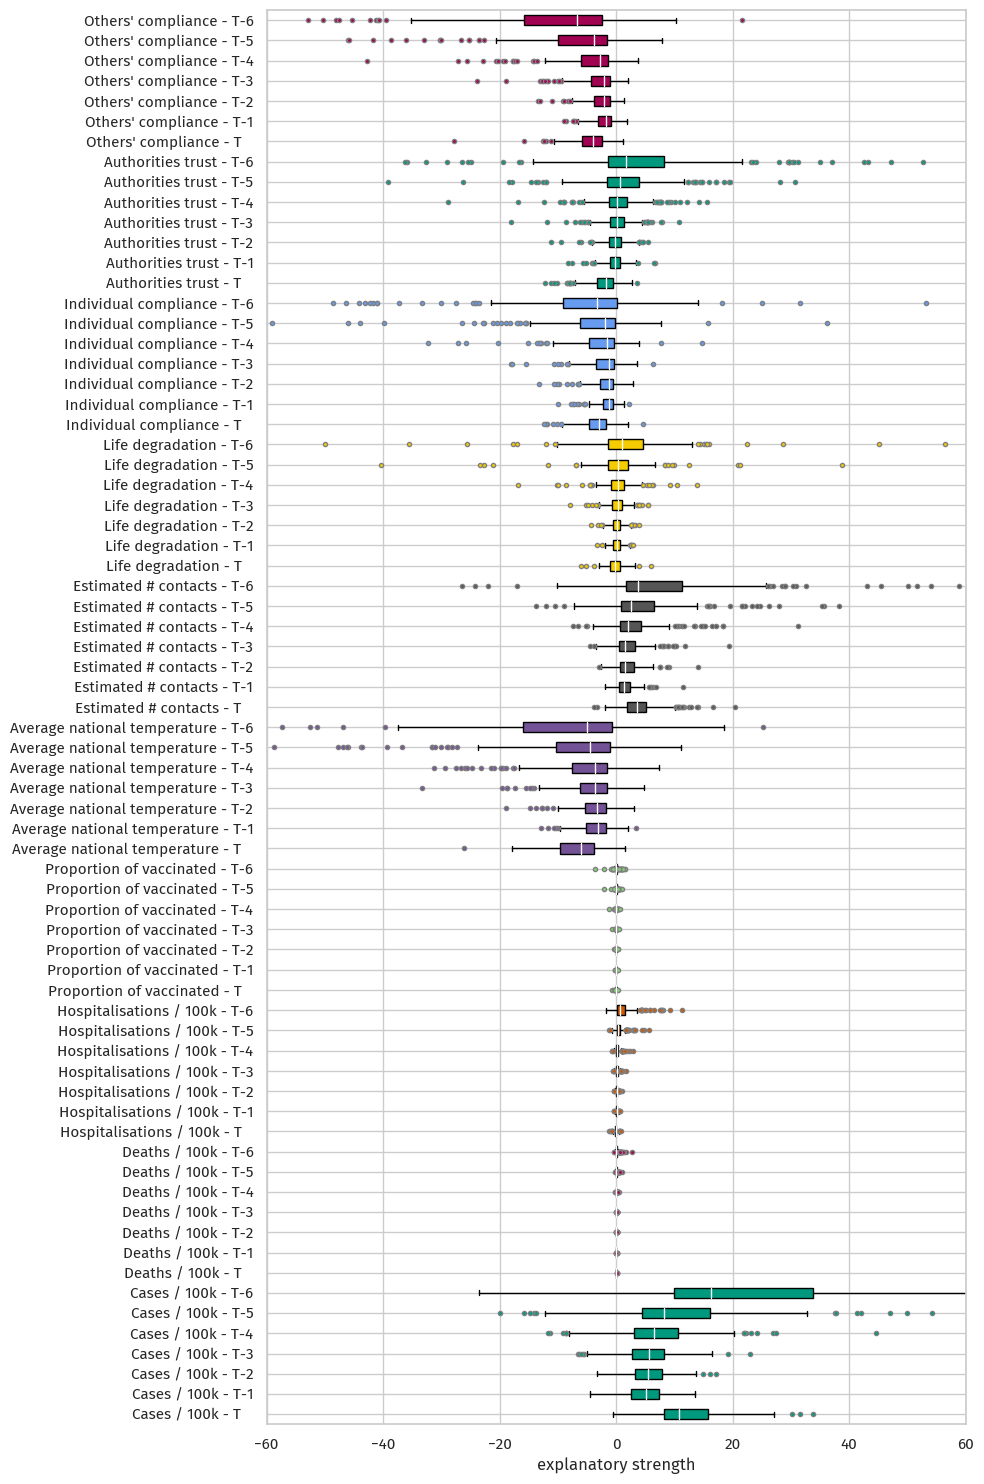

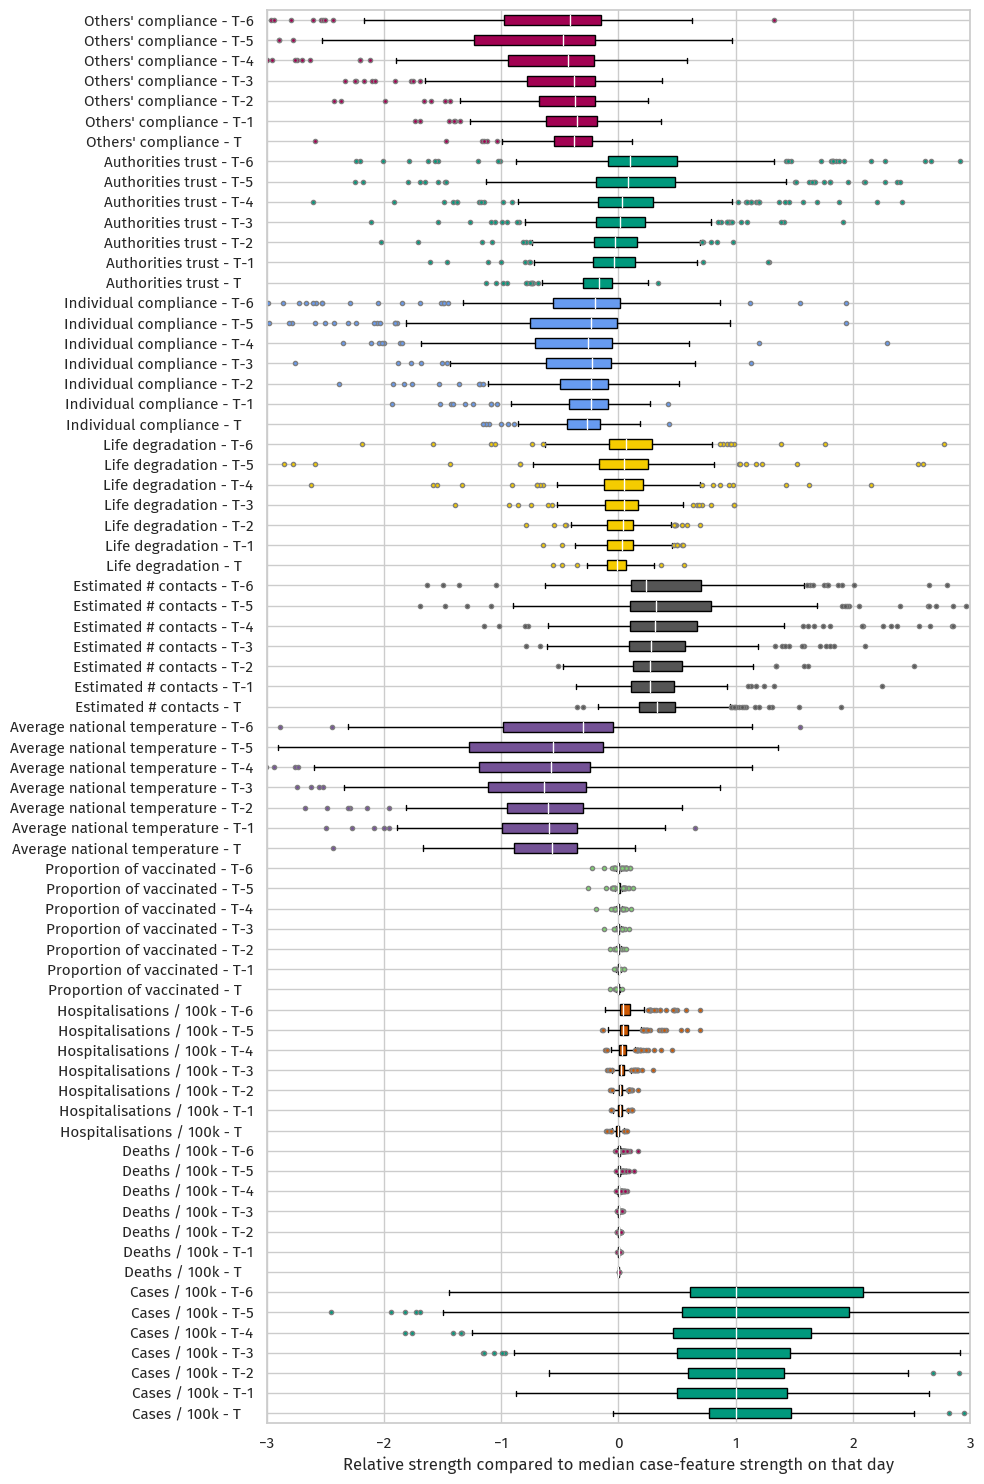

In [44]:
def get_str(x):
    avg = x.mean(axis=0)
    std = x.std(axis=0)
    
    med = np.median(x, axis=0)
    q2_5 = np.quantile(x, q=0.025, axis=0)
    q97_5 = np.quantile(x, q=0.975, axis=0)
    q25 = np.quantile(x, q=0.25, axis=0)
    q75 = np.quantile(x, q=0.75, axis=0)
    
    out = list()
    
    for i in range(x.shape[1]):
        out.append(list())
        for j in range(x.shape[2]):
            #out[-1].append(f'{avg[i][j]:.2f} (±{std[i][j]:.2f})')
            out[-1].append(f'{med[i][j]:.2f}  [{q25[i][j]:.2f}, {q75[i][j]:.2f}]')
            
    return out
rel_expl = explanations / (np.median(explanations,axis=0)[-1,:])[None,None,:]

annots = get_str(rel_expl)
YLABELS = [
    "Others' compliance",
    'Authorities trust',
    'Individual compliance',
    'Life degradation',
    'Estimated # contacts',
    'Average national temperature',
    'Proportion of vaccinated',
    'Hospitalisations / 100k',
    'Deaths / 100k',
    'Cases / 100k'
]

print('Explanation using LRP:')

_, ax = plt.subplots(figsize=(20,6))

sns.heatmap(np.median(rel_expl,axis=0), vmin=-1, vmax=1, 
            annot=get_str(rel_expl), fmt='', cmap='vlag', ax=ax,
            xticklabels=[f'T{i}' if i <0 else 'T' for i in range(-explanations.shape[2]+1, 1)],
            yticklabels=YLABELS)

plt.savefig('figures/paper/explanations/relative_explanations_lrp_loo_cases_for_all_smoothed_data.png', bbox_inches='tight', pad_inches=0., dpi=500)

_, ax = plt.subplots(figsize=(20,6))

sns.heatmap(np.median(explanations,axis=0), vmin=-1, vmax=1, 
            annot=get_str(explanations), fmt='', cmap='vlag', ax=ax,
            xticklabels=[f'T{i}' if i <0 else 'T' for i in range(-explanations.shape[2]+1, 1)],
            yticklabels=YLABELS)

plt.savefig('figures/paper/explanations/explanations_lrp_loo_cases_for_all_smoothed_data.png', bbox_inches='tight', pad_inches=0., dpi=500)

_rel_expl = np.einsum('ijk->ikj',rel_expl)
_rel_expl = np.vstack(_rel_expl)

med = np.median(_rel_expl, axis=0)
q2_5 = np.quantile(_rel_expl, q=0.025, axis=0)
q97_5 = np.quantile(_rel_expl, q=0.975, axis=0)
q25 = np.quantile(_rel_expl, q=0.25, axis=0)
q75 = np.quantile(_rel_expl, q=0.75, axis=0)

lines = []
latex = []
for i, label in enumerate(YLABELS):
    s = "{:+4.2f}  {:+4.2f}  {:+4.2f}  {:+4.2f}  {:+4.2f}  --  {:s}".format(q2_5[i], q25[i], med[i], q75[i], q97_5[i], label)
    s2 = "{:s} & {:4.2f} & {:4.2f} & {:4.2f} & {:4.2f} & {:4.2f}".format(label, q2_5[i], q25[i], med[i], q75[i], q97_5[i])
    lines.append((s, np.abs(med[i])))
    latex.append((s2, np.abs(med[i])))
lines = sorted(lines, key=lambda x:-x[-1])
latex = sorted(latex, key=lambda x:-x[-1])

for l, _ in lines:
    print(l)
    
print(r"""
    \begin{tabular}{rrrrrr}
        \toprule
             & \textbf{Q2.5} & \textbf{Q25} & \textbf{Median} & \textbf{Q75} & \textbf{Q97.5} \\
        \midrule""")
for l, _ in latex:
    print("            " + l + r"\\")
print(r"""         \bottomrule
    \end{tabular}""")
    
ax = boxplots(explanations, YLABELS)
ax.set_xlabel("explanatory strength")
ax.set_xlim(-60,60)
#ax.set_title("Explanatory strength")
ax.get_figure().tight_layout()
ax.get_figure().savefig('figures/paper/explanations/boxplots_for_all_smoothed_data_absolute_explanatory_strength.png',dpi=300)

ax = boxplots(rel_expl, YLABELS)
ax.set_xlabel("Relative strength compared to median case-feature strength on that day")
ax.set_xlim(-3,3)
ax.get_figure().tight_layout()
ax.get_figure().savefig('figures/paper/explanations/boxplots_for_all_smoothed_data_relative_explanatory_strength.png',dpi=300)
#ax.set_title("Relative explanatory strength")



Explanation using IG:


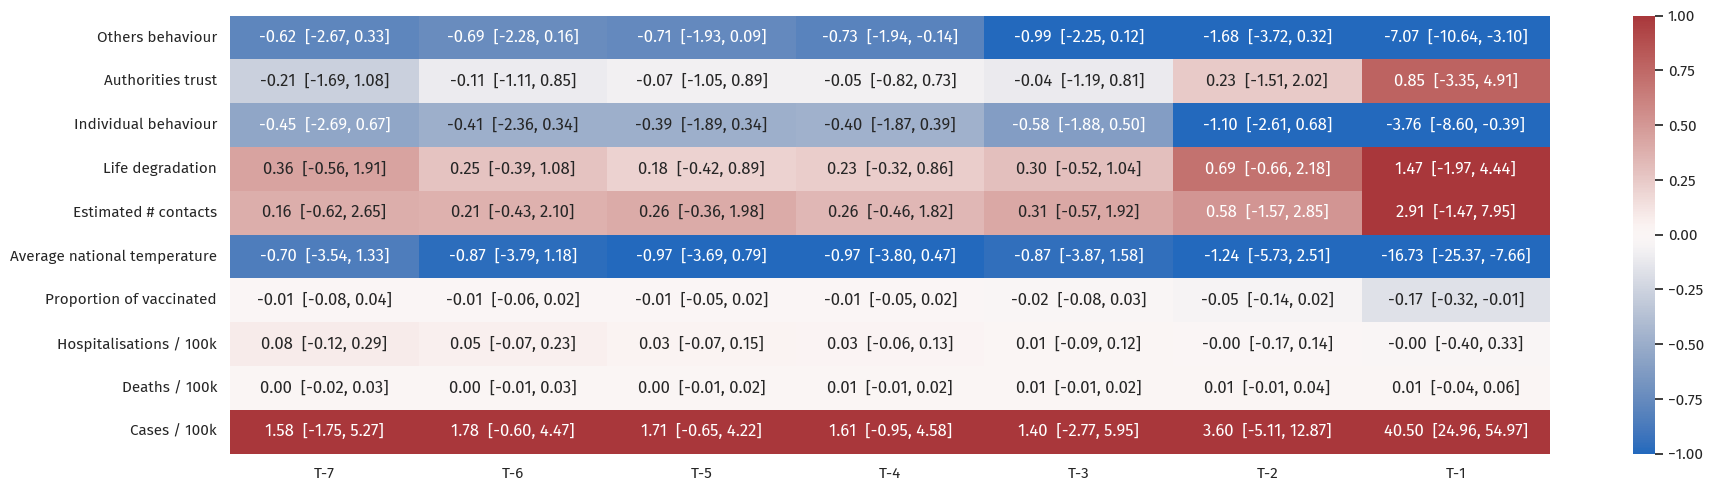

In [55]:
def get_str(x):
    avg = x.mean(axis=0)
    std = x.std(axis=0)
    
    med = np.median(x, axis=0)
    q2_5 = np.quantile(x, q=0.025, axis=0)
    q97_5 = np.quantile(x, q=0.975, axis=0)
    
    out = list()
    
    for i in range(x.shape[1]):
        out.append(list())
        for j in range(x.shape[2]):
            #out[-1].append(f'{avg[i][j]:.2f} (±{std[i][j]:.2f})')
            out[-1].append(f'{med[i][j]:.2f}  [{q2_5[i][j]:.2f}, {q97_5[i][j]:.2f}]')
            
    return out

integrated_gradients = np.array(integrated_gradients)
annots = get_str(integrated_gradients)

print('Explanation using IG:')

_, ax = plt.subplots(figsize=(20,6))

sns.heatmap(integrated_gradients.mean(axis=0), vmin=-1, vmax=1, 
            annot=annots, fmt='', cmap='vlag', ax=ax,
            xticklabels=[f'T{i}' for i in range(-integrated_gradients.shape[2], 0)],
            yticklabels=YLABELS)

plt.savefig('figures/paper/ig_loo_cases.png', bbox_inches='tight', pad_inches=0., dpi=500)
#plt.show()

In [56]:
df_X

Others behaviour_smooth  Authorities trust_smooth  Individual behaviour_smooth  Life degradation_smooth  Estimated # contacts  temperature_smooth  proportion_second_dose  hospit_per_100000_smooth  deaths_per_100000_smooth  cases_per_100000_smooth
Day                                                                                                                                                                                                                                                               
2020-07-04                 4.942787                  5.604178                     5.260365                 3.507372              5.577544           14.808606                0.000000                  0.023350                  0.000000                 0.058374
2020-07-05                 4.933647                  5.578479                     5.235464                 3.500158              5.332283           14.380028                0.000000                  0.023350                  0.000000                 0.070049
2020-07-06                 4.925267                  5.560890                     5.244597                 3.468787              5.244296           14.044699                0.000000                  0.023350                  0.000000                 0.070049
2020-07-07                 4.971552                  5.606568                     5.280261                 3.441477              5.243372           13.804766                0.000000                  0.023350                  0.000000                 0.105073
2020-07-08                 4.923984                  5.596436                     5.230133                 3.430844              5.495521           13.570409                0.000000                  0.023350                  0.000000                 0.105073
...                             ...                       ...                          ...                      ...                   ...                 ...                     ...                       ...                       ...                      ...
2021-12-02                 4.674907                  5.318845                     4.878244                 3.277076              6.960210            2.177714                0.743811                  1.120783                  0.186797                65.997793
2021-12-03                 4.653459                  5.289154                     4.866668                 3.234520              6.888531            2.078278                0.744451                  1.062409                  0.163448                69.126646
2021-12-04                 4.647249                  5.251354                     4.899852                 3.275649              6.894016            1.909940                0.744949                  0.980685                  0.140098                71.379887
2021-12-05                 4.656963                  5.259622                     4.923899                 3.276184              6.796529            1.748648                0.745482                  1.027385                  0.175122                74.181846
2021-12-06                 4.674359                  5.252513                     4.932155                 3.327913              6.822922            1.825198                0.746175                  0.969011                  0.128423                67.060202

[521 rows x 10 columns]

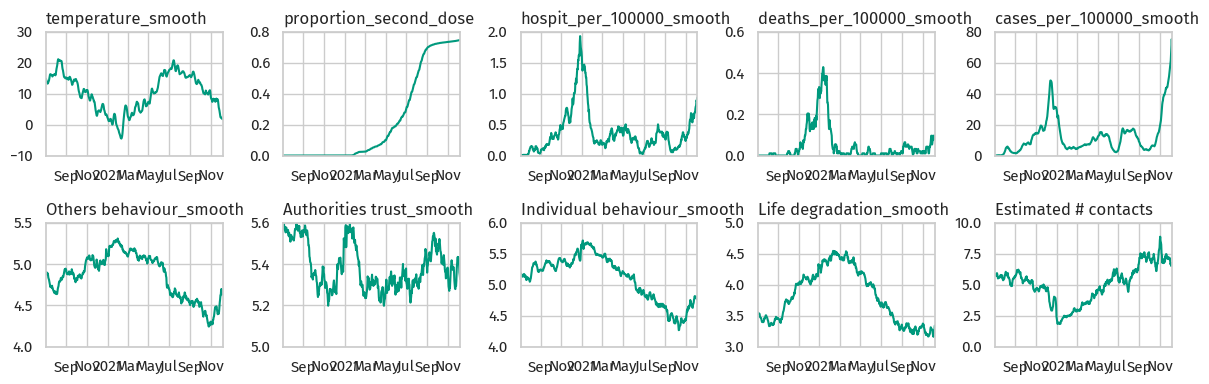

In [57]:
fig, ax = plt.subplots(2,5,figsize=(12,4))
region = 'Midtjylland'
df_X = df_regions.loc[region].dropna().copy()
df_X = df_X.astype('float')
for i, _FEATURES in enumerate([OTHER_FEATURES, SURVEY_FEATURES]):
    for j, _FEATURE in enumerate(_FEATURES):
        ax[i,j].plot(df_X.index, df_X[_FEATURE])
        ax[i,j].set_title(_FEATURE)
fig.tight_layout()